In [1]:
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats import multicomp
import requests
import os
import gmaps
from config import gkey
from scipy.stats import linregress

# Configure gmaps
gmaps.configure(api_key=gkey)

## Infant Mortality by Race

In [2]:
dfImrByCountyByRace = pd.read_csv("datafiles/IMR by county by race, 2007-2016.txt", sep='\t')
dfImrByCountyByRace.dropna(subset=['Death Rate'], inplace=True)


In [3]:
# remove rows with unreliable death rate data (fewer than 20 deaths)
dfImrByCountyByRace = dfImrByCountyByRace.loc[dfImrByCountyByRace['Death Rate'].map(lambda x: 'Unreliable' not in str(x))]

# convert death rate to float
dfImrByCountyByRace['Death Rate'] = dfImrByCountyByRace['Death Rate'].map(lambda x: float(x))


In [4]:
blacks = dfImrByCountyByRace.loc[dfImrByCountyByRace['Race Code'] == '2054-5']['Death Rate']
natives = dfImrByCountyByRace.loc[dfImrByCountyByRace['Race Code'] == '1002-5']['Death Rate']
whites = dfImrByCountyByRace.loc[dfImrByCountyByRace['Race Code'] == '2106-3']['Death Rate']
asians = dfImrByCountyByRace.loc[dfImrByCountyByRace['Race Code'] == 'A-PI']['Death Rate']
unknown = dfImrByCountyByRace.loc[dfImrByCountyByRace['Race'] == 'Unknown']['Death Rate']


C:\Users\jasmi\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


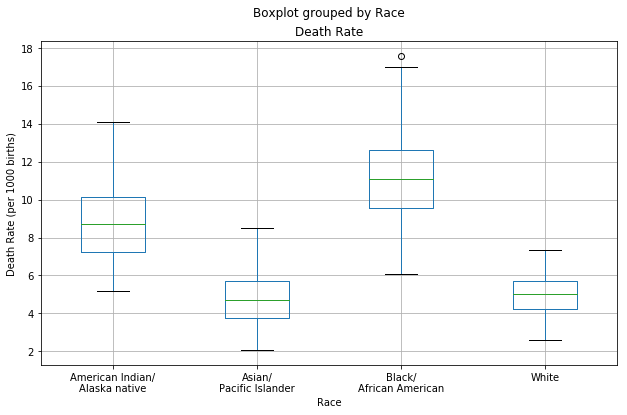

In [5]:
ax = dfImrByCountyByRace.boxplot('Death Rate', by="Race", figsize=(10, 6))
fig = ax.get_figure()
ax.set_xticklabels (['American Indian/\nAlaska native', 'Asian/\nPacific Islander', 'Black/\nAfrican American', 'White'])
ax.set_ylabel('Death Rate (per 1000 births)')
fig.savefig('Images/Death Rate by Race.png')
fig.show()

### ANOVA shows that one (or more) race(s) is significantly different than the rest

In [6]:
stats.f_oneway(blacks, natives, whites, asians)

F_onewayResult(statistic=750.6014547203422, pvalue=4.2275575569554066e-222)

In [7]:
blacksByCounty = dfImrByCountyByRace.set_index(['Race', 'County']).sort_values(['Race', 'Death Rate'], ascending=False).loc['Black or African American']
blacksByCounty = blacksByCounty.loc[blacksByCounty['Death Rate'].notnull()]

In [8]:
blacksHighestImrCounties = blacksByCounty.head(10)
blacksHighestImrCounties.to_csv("datafiles/AfricanAmericanHighestImrCounties.csv")

In [9]:
blacksLowestImrCounties = blacksByCounty.tail(10)
blacksLowestImrCounties.to_csv("datafiles/AfricanAmericanLowestImrCounties.csv")

In [10]:
# use pairwise tukeyhsd to find out which race is significnalty different than the rest  
answer = multicomp.pairwise_tukeyhsd(dfImrByCountyByRace['Death Rate'], dfImrByCountyByRace['Race'], alpha=0.05)

In [11]:
# reject True proves the hypothesis - that there is significant difference between two means
print(answer)

                    Multiple Comparison of Means - Tukey HSD,FWER=0.05                    
             group1                        group2          meandiff  lower   upper  reject
------------------------------------------------------------------------------------------
American Indian or Alaska Native Asian or Pacific Islander -4.0327  -4.8902 -3.1751  True 
American Indian or Alaska Native Black or African American  2.3376   1.5157  3.1595  True 
American Indian or Alaska Native           White           -3.8264  -4.6396 -3.0131  True 
   Asian or Pacific Islander     Black or African American  6.3702   5.9138  6.8267  True 
   Asian or Pacific Islander               White            0.2063  -0.2344  0.647  False 
   Black or African American               White           -6.1639  -6.5305 -5.7973  True 
------------------------------------------------------------------------------------------


## Infant Mortality by Race, 2007-2016

In [12]:
dfImrByYearByRace = pd.read_csv("datafiles/imr by year by race, 2007-2016.txt", sep='\t')

In [13]:
dfImrByYearByRace.dropna(subset=['Year of Death'], inplace=True)
dfImrByYearByRace['Race'] = ['Unknown' if myrace is np.nan else myrace for myrace in dfImrByYearByRace['Race']]

In [14]:
dfImrByYearByRace.head()

,Notes,Year of Death,Year of Death Code,Race,Race Code,Deaths,Births,Death Rate
0,NaN,2007.0,2007.0,American Indian or Alaska Native,1002-5,456.0,49443.0,9.22
1,NaN,2007.0,2007.0,Asian or Pacific Islander,A-PI,1216.0,254488.0,4.78
2,NaN,2007.0,2007.0,Black or African American,2054-5,8732.0,675676.0,12.92
3,NaN,2007.0,2007.0,White,2106-3,18749.0,3336626.0,5.62
4,Total,2007.0,2007.0,Unknown,NaN,29153.0,4316233.0,6.75


In [15]:
dfPlot = dfImrByYearByRace.pivot('Year of Death', 'Race', 'Death Rate')
dfPlot.reset_index(inplace=True)


In [16]:
dfPlot.head()

Race,Year of Death,American Indian or Alaska Native,Asian or Pacific Islander,Black or African American,Unknown,White
0,2007.0,9.22,4.78,12.92,6.75,5.62
1,2008.0,8.42,4.51,12.37,6.61,5.56
2,2009.0,8.47,4.40,12.12,6.39,5.33
3,2010.0,8.28,4.27,11.21,6.14,5.21
4,2011.0,8.21,4.36,11.15,6.07,5.12


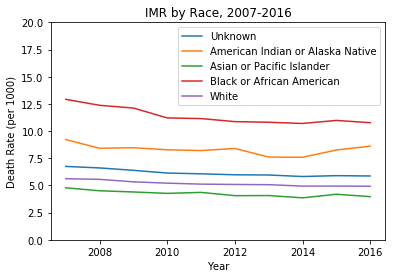

In [17]:
plt.plot(dfPlot['Year of Death'], dfPlot['Unknown'], label='Unknown')
plt.plot(dfPlot['Year of Death'], dfPlot['American Indian or Alaska Native'], label='American Indian or Alaska Native')
plt.plot(dfPlot['Year of Death'], dfPlot['Asian or Pacific Islander'], label='Asian or Pacific Islander')
plt.plot(dfPlot['Year of Death'], dfPlot['Black or African American'], label='Black or African American')
plt.plot(dfPlot['Year of Death'], dfPlot['White'], label='White')
plt.ylim(0, 20)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Death Rate (per 1000)")
plt.title ("IMR by Race, 2007-2016")
plt.rcParams["figure.figsize"] = [8, 6]
plt.savefig("Images/IMR by Race, 2007-2016.png")
plt.show()

## Leading cause of infant mortality by age


In [18]:
# Death Rate by age
dfImrByAgeByCause = pd.read_csv("datafiles/IMR by age by cause, 2007-2016.txt", sep='\t')

# Convert NaN to Unknown for the age of infant
dfImrByAgeByCause['Age of Infant at Death'] = ["Unknown" if age is np.nan else age for age in dfImrByAgeByCause['Age of Infant at Death']]

# Remove rows with Unreliable in Death Rate column (fewer than 20 reported cases)
dfImrByAgeByCause = dfImrByAgeByCause.loc[dfImrByAgeByCause['Death Rate'].map(lambda x: 'Unreliable' not in str(x))]

# Convert Death Rate to float
dfImrByAgeByCause['Death Rate'] = dfImrByAgeByCause['Death Rate'].map(lambda x: float(x))

# Save totals in new df
dfTotalsbyAgebyCause = dfImrByAgeByCause.loc[(dfImrByAgeByCause['Notes']=='Total') & (dfImrByAgeByCause['Age of Infant at Death']!= 'Unknown')]

# Remove Totals and summary rows
dfImrByAgeByCause = dfImrByAgeByCause[(dfImrByAgeByCause['Notes']!="Total")& (dfImrByAgeByCause["Death Rate"].notnull())]

# Sort descending by Death Rate
dfImrByAgeByCause.sort_values(by='Death Rate', ascending=False, inplace=True)

dfImrByAgeByCause.head()


,Notes,Age of Infant at Death,Age of Infant at Death Code,Cause of death,Cause of death Code,Deaths,Births,Death Rate
701,NaN,1 - 23 hours,2.0,Extreme immaturity,P07.2,18147.0,40445070.0,0.45
3988,NaN,28 - 364 days,5.0,Sudden infant death syndrome - SIDS,R95,17167.0,40445070.0,0.42
163,NaN,Under 1 hour,1.0,Extreme immaturity,P07.2,10528.0,40445070.0,0.26
3990,NaN,28 - 364 days,5.0,Other ill-defined and unspecified causes of mo...,R99,8889.0,40445070.0,0.22
4071,NaN,28 - 364 days,5.0,Accidental suffocation and strangulation in bed,W75,6632.0,40445070.0,0.16


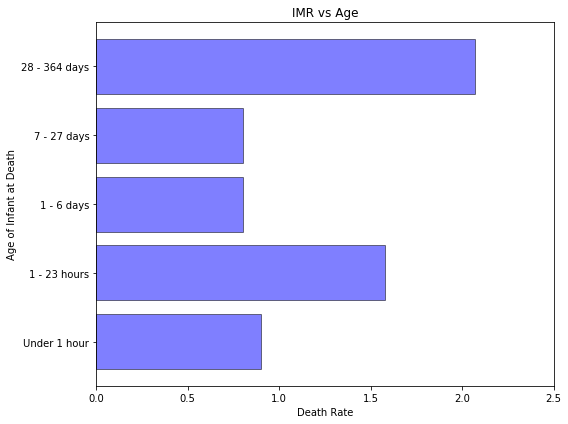

In [19]:
rects = plt.barh(dfTotalsbyAgebyCause['Age of Infant at Death'], width=dfTotalsbyAgebyCause['Death Rate'], color='blue', alpha=.5, edgecolor='black')
plt.title("IMR vs Age")
plt.ylabel("Age of Infant at Death")
plt.xlabel("Death Rate")
plt.xlim(0, 2.5)
plt.rcParams["figure.figsize"] = [10, 6]
plt.tight_layout()
plt.savefig("Images/IMR vs age.png")
plt.show()

In [20]:
# removes rows that show total
dfImrByAgeByCause = dfImrByAgeByCause.loc[(dfImrByAgeByCause['Notes'] != 'Total')].sort_values(by=['Death Rate'], ascending=False).head(20)

In [21]:
indexedImrByAgeByCause = dfImrByAgeByCause.set_index(["Age of Infant at Death", "Cause of death"])
indexedImrByAgeByCause.sort_values(["Age of Infant at Death Code", "Death Rate"], ascending=[True, False], inplace=True)
indexedImrByAgeByCause.head()

Notes  \
Age of Infant at Death Cause of death                                             
Under 1 hour           Extreme immaturity                                   NaN   
                       Other preterm infants                                NaN   
                       Newborn affected by premature rupture of membranes   NaN   
                       Newborn affected by incompetent cervix               NaN   
1 - 23 hours           Extreme immaturity                                   NaN   

                                                                           Age of Infant at Death Code  \
Age of Infant at Death Cause of death                                                                    
Under 1 hour           Extreme immaturity                                                          1.0   
                       Other preterm infants                                                       1.0   
                       Newborn affected by premature rupture of membranes                          1.0   
                       Newborn affected by incompetent cervix                                      1.0   
1 - 23 hours           Extreme immaturity                                                          2.0   

                                                                          Cause of death Code  \
Age of Infant at Death Cause of death                                                           
Under 1 hour           Extreme immaturity                                               P07.2   
                       Other preterm infants                                            P07.3   
                       Newborn affected by premature rupture of membranes               P01.1   
                       Newborn affected by incompetent cervix                           P01.0   
1 - 23 hours           Extreme immaturity                                               P07.2   

                                                                            Deaths  \
Age of Infant at Death Cause of death                                                
Under 1 hour           Extreme immaturity                                  10528.0   
                       Other preterm infants                                3615.0   
                       Newborn affected by premature rupture of membranes   3061.0   
                       Newborn affected by incompetent cervix               1834.0   
1 - 23 hours           Extreme immaturity                                  18147.0   

                                                                               Births  \
Age of Infant at Death Cause of death                                                   
Under 1 hour           Extreme immaturity                                  40445070.0   
                       Other preterm infants                               40445070.0   
                       Newborn affected by premature rupture of membranes  40445070.0   
                       Newborn affected by incompetent cervix              40445070.0   
1 - 23 hours           Extreme immaturity                                  40445070.0   

                                                                           Death Rate  
Age of Infant at Death Cause of death                                                  
Under 1 hour           Extreme immaturity                                        0.26  
                       Other preterm infants                                     0.09  
                       Newborn affected by premature rupture of membranes        0.08  
                       Newborn affected by incompetent cervix                    0.05  
1 - 23 hours           Extreme immaturity                                        0.45

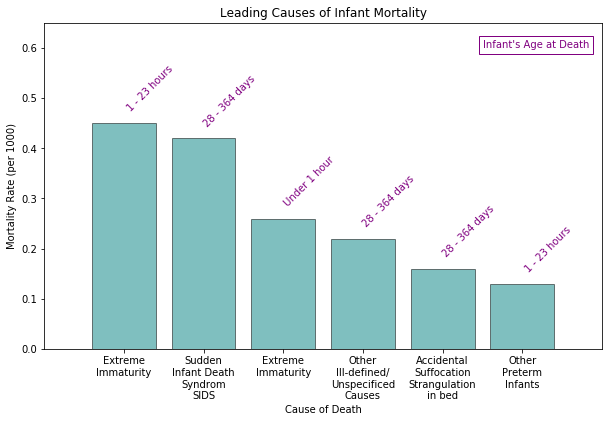

In [22]:
x_axis = dfImrByAgeByCause['Cause of death'].head(6)

y_axis = dfImrByAgeByCause['Death Rate'].head(6)
rects = plt.bar(range(len(x_axis)),y_axis, color='teal', alpha=0.5, edgecolor='black' )

plt.xticks(range(len(x_axis)), ['Extreme\nImmaturity', 'Sudden\nInfant Death\nSyndrom\nSIDS', 'Extreme\nImmaturity', 'Other\nIll-defined/\nUnspecificed\nCauses', 'Accidental\nSuffocation\nStrangulation\nin bed', 'Other\nPreterm\nInfants'], rotation='horizontal')
plt.xlim(-1,6)
plt.ylim(0, 0.65)
for rect in rects:
    indx = rects.index(rect)
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/1.1, height + 0.02,
             dfImrByAgeByCause['Age of Infant at Death'].iloc[indx],
             ha='center', va='bottom', color='purple', rotation = 45)
plt.text(4.5,0.6, "Infant's Age at Death", color="purple", bbox=dict(facecolor='none', edgecolor='purple'))
   
plt.xlabel("Cause of Death")
plt.ylabel("Mortality Rate (per 1000)")
plt.title("Leading Causes of Infant Mortality")
plt.rcParams["figure.figsize"] = [12, 8]
# plt.tight_layout()
plt.savefig("Images/Leading Causes of Infant Mortality.png")
plt.show()

## Leading cause of infant mortality by race


In [23]:
dfImrByRaceByCause = pd.read_csv("datafiles/imr by race by cause, 2007-2016.txt", sep='\t')

# remove Unreliable from Death Rate colum (fewer than 20 reported cases)
dfImrByRaceByCause = dfImrByRaceByCause.loc[dfImrByRaceByCause['Death Rate'].map(lambda x: 'Unreliable' not in str(x))]

# remove totals
dfImrByRaceByCause = dfImrByRaceByCause[(dfImrByRaceByCause['Notes']!='Total') & dfImrByRaceByCause['Death Rate'].notnull()]

# convert death rate to float
dfImrByRaceByCause['Death Rate'] = dfImrByRaceByCause['Death Rate'].map(lambda x: float(x))

# sort by race ascending, death rate descending
dfImrByRaceByCause = dfImrByRaceByCause.sort_values(['Race', 'Death Rate'], ascending=[True, False])

dfImrByRaceByCause.head()


,Notes,Race,Race Code,Cause of death,Cause of death Code,Deaths,Births,Death Rate
117,NaN,American Indian or Alaska Native,1002-5,Sudden infant death syndrome - SIDS,R95,48.0,43555.0,1.10
118,NaN,American Indian or Alaska Native,1002-5,Other ill-defined and unspecified causes of mo...,R99,39.0,43555.0,0.90
43,NaN,American Indian or Alaska Native,1002-5,Extreme immaturity,P07.2,31.0,43555.0,0.71
248,NaN,Asian or Pacific Islander,A-PI,Extreme immaturity,P07.2,171.0,302283.0,0.57
369,NaN,Asian or Pacific Islander,A-PI,Other ill-defined and unspecified causes of mo...,R99,50.0,302283.0,0.17


In [24]:
causes = x_axis.unique()
races = dfImrByRaceByCause['Race'].unique()

In [25]:
mylist = []
for cause in causes:
    for thisrace in races:
        if ((dfImrByRaceByCause['Cause of death'] == cause) & (dfImrByRaceByCause['Race'] == thisrace)).any():
            myrow = dfImrByRaceByCause.loc[(dfImrByRaceByCause['Cause of death'] == cause) & (dfImrByRaceByCause['Race'] == thisrace)]
            mylist.append({
                'Race': thisrace,
                'Cause of death': cause,
                'Death Rate' : myrow.iloc[0]['Death Rate']})
        else:
            mylist.append({
                'Race': thisrace,
                'Cause of death': cause,
                'Death Rate' : 0})

dfImrByRaceByCausePlotting = pd.DataFrame(mylist)

dfImrByRaceByCausePlotting = dfImrByRaceByCausePlotting.pivot(index='Race', columns='Cause of death', values='Death Rate')

dfImrByRaceByCausePlotting = dfImrByRaceByCausePlotting[[
 'Extreme immaturity',
 'Sudden infant death syndrome - SIDS',
 'Other ill-defined and unspecified causes of mortality',
 'Accidental suffocation and strangulation in bed',
 'Other preterm infants']]


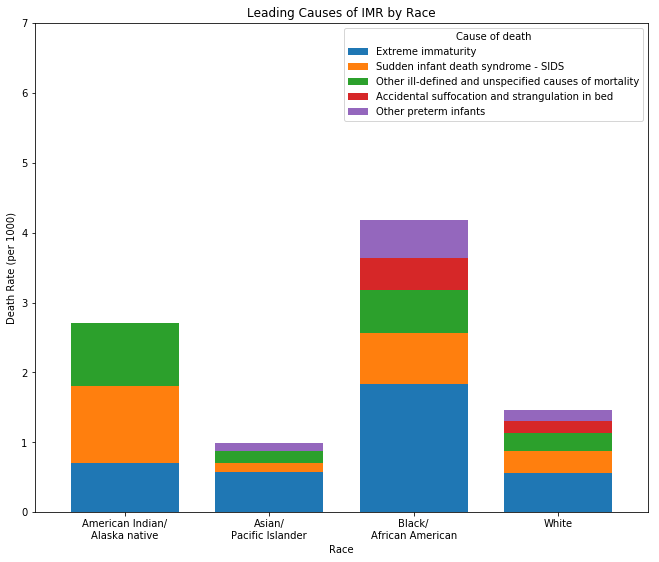

In [26]:
ax = dfImrByRaceByCausePlotting.plot.bar(stacked=True, ylim=(0,7), figsize=(11, 9),  width=0.75, title="Leading Causes of IMR by Race", rot=0)
ax.set_ylabel("Death Rate (per 1000)")
ax.set_xticklabels (['American Indian/\nAlaska native', 'Asian/\nPacific Islander', 'Black/\nAfrican American', 'White'])
fig = ax.get_figure()
fig.savefig('Images/Leading Causes of IMR by Race.png')

## IMR by Month Prenatal Care Began


In [27]:
dfImrByPrenatalCareStart = pd.read_csv("./datafiles/imr by prenatal care start, 2007-2016.txt", sep='\t')

In [28]:
dfImrByPrenatalCareStart = dfImrByPrenatalCareStart[['Month Prenatal Care Began', 'Death Rate']].dropna(subset=["Month Prenatal Care Began", "Death Rate"])

In [29]:
dfImrByPrenatalCareStart


,Month Prenatal Care Began,Death Rate
0,No prenatal care,26.89
1,1st month,7.42
2,2nd month,4.69
3,3rd month,4.82
4,4th month,5.87
5,5th month,7.06
6,6th month,6.58
7,7th month,5.43
8,8th month,5.07
9,9th month,4.11


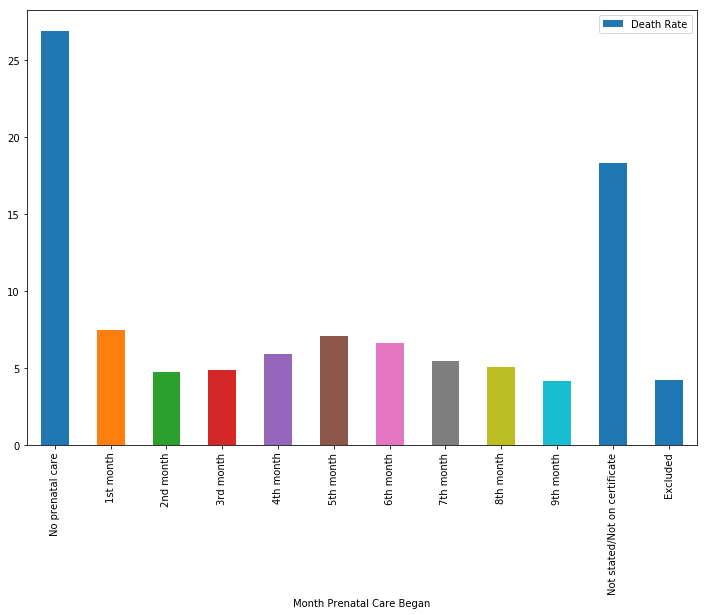

In [30]:
dfImrByPrenatalCareStart.plot("Month Prenatal Care Began", "Death Rate", kind='bar')

In [31]:
dfImrByPrenatalByRace = pd.read_csv("datafiles/IMR By prenatal care by race, 2007-2016.txt", sep='\t')

In [32]:
dfNoPrenatalcareByRace = dfImrByPrenatalByRace.loc[(dfImrByPrenatalByRace['Month Prenatal Care Began'] == 'No prenatal care') & (dfImrByPrenatalByRace['Notes']!='Total')]
dfNoPrenatalcareByRace['Death Rate'] = [float(x) for x in dfNoPrenatalcareByRace['Death Rate']]



C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
df1stMonthPrenatalcareByRace = dfImrByPrenatalByRace.loc[(dfImrByPrenatalByRace['Month Prenatal Care Began'] == '1st month') & (dfImrByPrenatalByRace['Notes']!='Total')]
df1stMonthPrenatalcareByRace['Death Rate'] = [0 if 'Unreliable' in str(x) else x for x in df1stMonthPrenatalcareByRace['Death Rate']]
df1stMonthPrenatalcareByRace['Death Rate'] = [float(x) for x in df1stMonthPrenatalcareByRace['Death Rate']]


C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


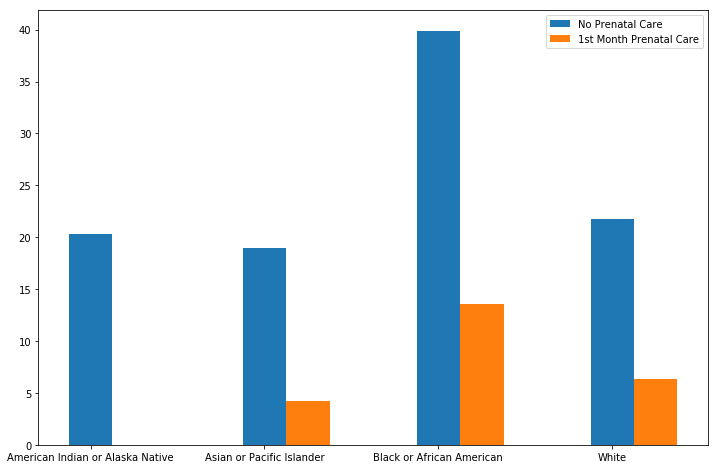

In [34]:
plt.bar(np.arange(len(dfNoPrenatalcareByRace['Race'])), dfNoPrenatalcareByRace['Death Rate'], label='No Prenatal Care', width=0.25)
plt.bar(np.arange(len(df1stMonthPrenatalcareByRace['Race'])) + 0.25, df1stMonthPrenatalcareByRace['Death Rate'], label='1st Month Prenatal Care', width=0.25)
plt.xticks(np.arange(len(dfNoPrenatalcareByRace['Race'])), dfNoPrenatalcareByRace['Race'])
plt.legend()

## Percent of Premature Births by Race

In [35]:
dfExtremePrematurityByRace = pd.read_csv("datafiles/extreme prematurity by race, 2007-2017.txt", sep='\t')

In [36]:
def totalForRace(df, race):
    total = df.loc[df['Bridged Race'] == race]['Births'].mean()
    return total
    

In [37]:
dfExtremePrematurityByRace.dropna(subset=['Births'], inplace=True)

In [38]:
totalForRace(dfExtremePrematurityByRace, "White")

285784.5

In [39]:
totalForRace(dfExtremePrematurityByRace, "Black or African American")

65811.5

In [40]:
dfExtremePrematurityByRace['Total for Race'] = dfExtremePrematurityByRace.apply((lambda x: totalForRace(dfExtremePrematurityByRace, x['Bridged Race'])), axis=1) 

In [41]:
dfExtremePrematurityAfricanAmerican = dfExtremePrematurityByRace.loc[dfExtremePrematurityByRace['Bridged Race'] == 'Black or African American']

In [42]:
dfExtremePrematurity20to27 = dfExtremePrematurityByRace.loc[dfExtremePrematurityByRace['OE Gestational Age 10'] == '20 - 27 weeks']

In [43]:
dfExtremePrematurity20to27['Percent of Total Births'] = dfExtremePrematurity20to27.apply((lambda row: row['Births']/row['Total for Race']*100), axis=1)

C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
dfExtremePrematurity20to27

,Notes,OE Gestational Age 10,OE Gestational Age 10 Code,Bridged Race,Bridged Race Code,Births,Total for Race,Percent of Total Births
4,NaN,20 - 27 weeks,2.0,American Indian or Alaska Native,1002-5,291.0,4191.6,6.942456
5,NaN,20 - 27 weeks,2.0,Asian or Pacific Islander,A-PI,1505.0,29762.4,5.056716
6,NaN,20 - 27 weeks,2.0,Black or African American,2054-5,8858.0,65811.5,13.459654
7,NaN,20 - 27 weeks,2.0,White,2106-3,13870.0,285784.5,4.853307


## US IMR Compared to Other Wealthy Nations

In [45]:
dfWhoByCountry = pd.read_csv("datafiles/who by country.csv.csv", header=1)

In [46]:
dfWhoByCountry.rename(columns={'Both sexes':'IMR'}, inplace=True)
dfWhoByCountry.loc[dfWhoByCountry['Country'] == 'United Kingdom of Great Britain and Northern Ireland', 'Country'] = 'United Kingdom'
dfWhoByCountry.head()

,Country,Year,IMR
0,Australia,2017,3.0
1,Australia,2016,3.1
2,Australia,2015,3.2
3,Australia,2014,3.3
4,Australia,2013,3.5


In [47]:
plotImrByCountry = dfWhoByCountry.groupby('Country').mean().sort_values(by='IMR', ascending=False)

In [48]:
plotImrByCountry.head()

,Year,IMR
Country,,
United States of America,2012,6.081818
New Zealand,2012,4.909091
Canada,2012,4.809091
United Kingdom,2012,4.172727
Switzerland,2012,3.881818


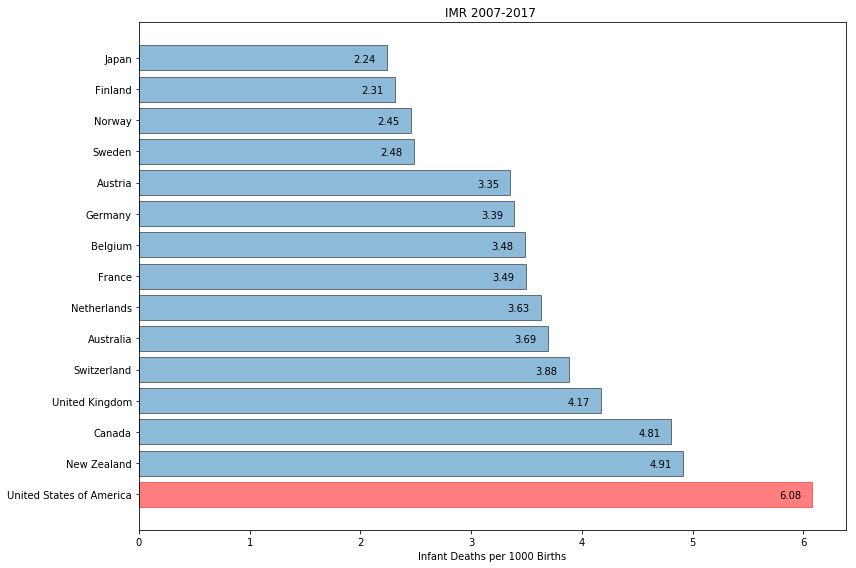

In [49]:
rects = plt.barh(plotImrByCountry.index, plotImrByCountry['IMR'], alpha=0.5, edgecolor='black')
plt.title("IMR 2007-2017 ")
plt.xlabel("Infant Deaths per 1000 Births")

for rect in rects:
    indx = rects.index(rect)
    width = rect.get_width()

    plt.text(width - 0.2, rect.get_y()+0.2,
         plotImrByCountry['IMR'].iloc[indx].round(2),
         ha='center', va='bottom', color='black', rotation = 'horizontal')
    
rects[0].set_color('red')
plt.rcParams["figure.figsize"] = [18, 10]
plt.savefig("Images/imr_by_country.png")
plt.tight_layout()
plt.show()

### Education levels vs Death Rate in USA by CDC

In [50]:
filename = 'datafiles/Education_Infant_Death_Records_2007_2016.csv'
filename_df = pd.read_csv(filename, encoding="ISO-8859-1")


education_sorted =filename_df.sort_values(["Death Rate"],ascending=False)

In [51]:
exclude_unknown = filename_df.loc[filename_df['Education']!= "Unknown/Not on certificate"]


In [52]:
exclude_excluded = exclude_unknown.loc[exclude_unknown['Education']!= "Excluded"]

In [53]:
del exclude_excluded['Deaths']
del exclude_excluded['Education Code']
del exclude_excluded['Births']
del exclude_excluded['Notes']
exclude_excluded

,Education,Death Rate
0,8th grade or less,6.18
1,9th -12th grade,8.16
2,HS or GED,7.13
3,Some college credit,6.01
4,Associate degree,4.87
5,Bachelor's degree,3.73
6,Master's degree,3.35
7,Doctorate degree,3.12


### AAR Education vs Death Rate

In [54]:
aareducation = 'datafiles/Death_Rate_by_AAR_by_Education.csv'
aareducation_df = pd.read_csv(aareducation, encoding="ISO-8859-1")

In [55]:
exclude_unknown_aar = aareducation_df.loc[aareducation_df['Education']!= "Unknown/Not on certificate"]



In [56]:
exclude_excluded_aar = exclude_unknown_aar.loc[exclude_unknown_aar['Education']!= "Excluded"]
exclude_excluded_aar

,Race,Race Code,Education,Death Rate
0,Black or African American,2054-5,8th grade or less,9.04
1,Black or African American,2054-5,9th - 12th grade,12.59
2,Black or African American,2054-5,HS or GED,11.62
3,Black or African American,2054-5,Some college credit,10.28
4,Black or African American,2054-5,Associate degree,9.80
5,Black or African American,2054-5,Bachelor's degree,8.18
6,Black or African American,2054-5,Master's degree,7.86
7,Black or African American,2054-5,Doctorate degree,6.20


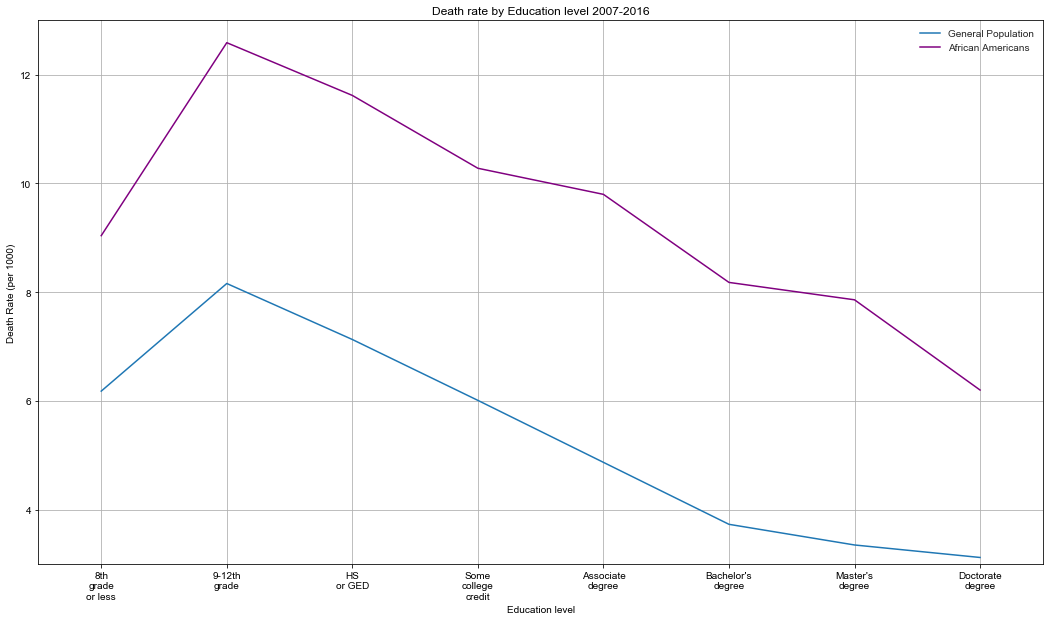

In [57]:
x_axis = exclude_excluded['Education']
y_axis = exclude_excluded['Death Rate']

# plt.plot(exclude_unknown["Education"],
#          exclude_unknown["Death Rate"]
         
#          )
plt.plot(x_axis, y_axis, label="General Population")

x_axis = exclude_excluded['Education']
y_axis = exclude_excluded_aar['Death Rate']

plt.plot(x_axis, y_axis, color="purple", label="African Americans")


# Incorporate the other graph properties
plt.style.use('seaborn')
plt.title(f"Death rate by Education level 2007-2016")
plt.ylabel("Death Rate (per 1000)")
plt.xlabel("Education level")
plt.grid(True)
plt.xticks((range(len(x_axis))), ["8th\ngrade\nor less", "9-12th\ngrade", "HS\nor GED", "Some\ncollege\ncredit", "Associate\ndegree",  "Bachelor's\ndegree", "Master's\ndegree", "Doctorate\ndegree"])
plt.xlim(-0.5, 7.5)
plt.ylim(3, 13)
plt.legend()
# Save the figure
plt.savefig("Images/Education_lever_line.png")

# Show plot
plt.show()

### Education level in USA by USDA

In [59]:
usdafilename = 'datafiles/Education_USDA.csv'
usdafilename_df = pd.read_csv(usdafilename, encoding="ISO-8859-1")

In [60]:
del usdafilename_df['Less than a high school diploma, 2013-17']
del usdafilename_df['High school diploma only, 2013-17']
del usdafilename_df["Some college or associate's degree, 2013-17"]
del usdafilename_df["Bachelor's degree or higher, 2013-17"]
del usdafilename_df["Unnamed: 11"]
        

In [61]:
usdafilename_df = usdafilename_df.dropna()
         

In [62]:
renamed_code = usdafilename_df.rename(columns={"FIPS Code":"GEOID"})
renamed_code['GEOID'] = renamed_code['GEOID'].map(lambda x: int(x))
renamed_code

,GEOID,State,Area name,"Percent of adults with less than a high school diploma, 2013-17","Percent of adults with a high school diploma only, 2013-17","Percent of adults completing some college or associate's degree, 2013-17","Percent of adults with a bachelor's degree or higher, 2013-17"
0,1001,AL,Autauga County,12.3,33.6,29.1,25.0
1,1003,AL,Baldwin County,9.8,27.8,31.7,30.7
2,1005,AL,Barbour County,26.9,35.5,25.5,12.0
3,1007,AL,Bibb County,17.9,43.9,25.0,13.2
4,1009,AL,Blount County,20.2,32.3,34.4,13.1
5,1011,AL,Bullock County,28.6,36.6,21.4,13.4
6,1013,AL,Butler County,18.9,40.4,24.5,16.1
7,1015,AL,Calhoun County,16.8,32.2,33.1,17.9
8,1017,AL,Chambers County,19.1,38.4,29.1,13.3
9,1019,AL,Cherokee County,20.5,38.2,28.9,12.5


In [63]:
gazfilename = 'datafiles/2017_Gaz_counties_national.csv'
gazfilename_df = pd.read_csv(gazfilename, encoding="ISO-8859-1")

In [64]:
del gazfilename_df['USPS']
del gazfilename_df['ANSICODE']
del gazfilename_df["NAME"]
del gazfilename_df["ALAND"]
del gazfilename_df['AWATER']
del gazfilename_df['ALAND_SQMI']
del gazfilename_df["AWATER_SQMI"]
gazfilename_df.head()


,GEOID,INTPTLAT,INTPTLONG
0,1001,32.532237,-86.646440
1,1003,30.659218,-87.746067
2,1005,31.870253,-85.405104
3,1007,33.015893,-87.127148
4,1009,33.977358,-86.566440


In [65]:
merge_table = pd.merge(renamed_code, gazfilename_df, on="GEOID")


In [66]:
merge_table.columns

Index(['GEOID', 'State', 'Area name',
       'Percent of adults with less than a high school diploma, 2013-17',
       'Percent of adults with a high school diploma only, 2013-17',
       'Percent of adults completing some college or associate's degree, 2013-17',
       'Percent of adults with a bachelor's degree or higher, 2013-17',
       'INTPTLAT',
       'INTPTLONG                                                                                                               '],
      dtype='object')

In [67]:
merge_table.columns = ['GEOID', 'State', 'Area name',
       'Percent of adults with less than a high school diploma, 2013-17',
       'Percent of adults with a high school diploma only, 2013-17',
       'Percent of adults completing some college or associate\'s degree, 2013-17',
       'Percent of adults with a bachelor\'s degree or higher, 2013-17',
       'INTPTLAT',
       'INTPTLONG']
merge_table.head()

,GEOID,State,Area name,"Percent of adults with less than a high school diploma, 2013-17","Percent of adults with a high school diploma only, 2013-17","Percent of adults completing some college or associate's degree, 2013-17","Percent of adults with a bachelor's degree or higher, 2013-17",INTPTLAT,INTPTLONG
0,1001,AL,Autauga County,12.3,33.6,29.1,25.0,32.532237,-86.646440
1,1003,AL,Baldwin County,9.8,27.8,31.7,30.7,30.659218,-87.746067
2,1005,AL,Barbour County,26.9,35.5,25.5,12.0,31.870253,-85.405104
3,1007,AL,Bibb County,17.9,43.9,25.0,13.2,33.015893,-87.127148
4,1009,AL,Blount County,20.2,32.3,34.4,13.1,33.977358,-86.566440


In [68]:
def weighted_education(row):
    a = row['Percent of adults with less than a high school diploma, 2013-17']*0
    b = row['Percent of adults with a high school diploma only, 2013-17']*0.4
    c = row["Percent of adults completing some college or associate's degree, 2013-17"]*0.6
    d = row["Percent of adults with a bachelor's degree or higher, 2013-17"]*0.8
    return (a+b+c+d)

In [69]:
merge_table['Weighted Education Score'] = merge_table.apply(weighted_education, axis=1)

In [70]:
merge_table

,GEOID,State,Area name,"Percent of adults with less than a high school diploma, 2013-17","Percent of adults with a high school diploma only, 2013-17","Percent of adults completing some college or associate's degree, 2013-17","Percent of adults with a bachelor's degree or higher, 2013-17",INTPTLAT,INTPTLONG,Weighted Education Score
0,1001,AL,Autauga County,12.3,33.6,29.1,25.0,32.532237,-86.646440,50.90
1,1003,AL,Baldwin County,9.8,27.8,31.7,30.7,30.659218,-87.746067,54.70
2,1005,AL,Barbour County,26.9,35.5,25.5,12.0,31.870253,-85.405104,39.10
3,1007,AL,Bibb County,17.9,43.9,25.0,13.2,33.015893,-87.127148,43.12
4,1009,AL,Blount County,20.2,32.3,34.4,13.1,33.977358,-86.566440,44.04
5,1011,AL,Bullock County,28.6,36.6,21.4,13.4,32.101759,-85.717261,38.20
6,1013,AL,Butler County,18.9,40.4,24.5,16.1,31.751667,-86.681969,43.74
7,1015,AL,Calhoun County,16.8,32.2,33.1,17.9,33.771706,-85.822513,47.06
8,1017,AL,Chambers County,19.1,38.4,29.1,13.3,32.915504,-85.394032,43.46
9,1019,AL,Cherokee County,20.5,38.2,28.9,12.5,34.069515,-85.654242,42.62


In [71]:
# Store latitude and longitude in locations
locations = merge_table[["INTPTLAT", "INTPTLONG"]]
# Plot Heatmap
fig = gmaps.figure()
BD = merge_table["Weighted Education Score"]
# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=BD , 
                                 dissipating=False, max_intensity=100,
                                 point_radius=0.5)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig


Figure(layout=FigureLayout(height='420px'))

### Education vs High IMR by counties

In [72]:
highcounties = 'datafiles/high_IMR_county.csv'
highcounties_df = pd.read_csv(highcounties, encoding="ISO-8859-1")
highcounties_df


,Unnamed: 0,index,County,County ID,Deaths,Births,Death Rate,Year,All Ages in Poverty Percent,Lat,Lng
0,0,115,"Caddo Parish, LA",22017,486,37838,12.84,2011.5,21.58,32.577195,-93.882423
1,1,116,"East Baton Rouge Parish, LA",22033,680,61916,10.98,2011.5,18.84,30.543930,-91.093131
2,2,153,"Hinds County, MS",28049,276,25226,10.94,2011.5,24.79,32.267788,-90.466017
3,3,127,"Baltimore city, MD",24510,976,90996,10.73,2011.5,22.42,39.300032,-76.610476
4,4,0,"Jefferson County, AL",1073,983,91579,10.73,2011.5,17.30,33.553444,-86.896536
5,5,264,"Shelby County, TN",47157,1482,140867,10.52,2011.5,20.83,35.183794,-89.895397
6,6,159,"St. Louis city, MO",29510,482,48971,9.84,2011.5,26.30,38.635699,-90.244582
7,7,216,"Hamilton County, OH",39061,1087,111518,9.75,2011.5,16.75,39.196927,-84.544187
8,8,146,"Wayne County, MI",26163,2337,241580,9.67,2011.5,23.87,42.284664,-83.261953
9,9,205,"Cumberland County, NC",37051,548,57261,9.57,2011.5,17.75,35.050192,-78.828719


In [73]:
coordinates3 = [
    (32.577195, -93.882423),
    (30.543930, -91.093131),
    (32.267788, -90.466017),
    (39.300032, -76.610476),
    (33.553444, -86.896536),
    (35.183794, -89.895397),
    (38.635699, -90.244582),
    (39.196927, -84.544187),
    (42.284664, -83.261953),
    (35.050192, -78.828719)
]

In [74]:
figure_layout3 = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig3 = gmaps.figure(layout=figure_layout3)

In [75]:
# Assign the marker layer to a variable
markers3 = gmaps.marker_layer(coordinates3)
# Add the layer to the map
fig.add_layer(markers3)
#fig

In [76]:
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(markers3)

fig

Figure(layout=FigureLayout(height='420px'))

### Education vs Low IMR by counties

In [77]:
lowcounties = 'datafiles/low_IMR_county.csv'
lowcounties_df = pd.read_csv(lowcounties, encoding="ISO-8859-1")
lowcounties_df


,Unnamed: 0,index,County,County ID,Deaths,Births,Death Rate,Year,All Ages in Poverty Percent,Lat,Lng
0,0,115,"Caddo Parish, LA",22017,486,37838,12.84,2011.5,21.58,32.577195,-93.882423
1,1,116,"East Baton Rouge Parish, LA",22033,680,61916,10.98,2011.5,18.84,30.543930,-91.093131
2,2,153,"Hinds County, MS",28049,276,25226,10.94,2011.5,24.79,32.267788,-90.466017
3,3,127,"Baltimore city, MD",24510,976,90996,10.73,2011.5,22.42,39.300032,-76.610476
4,4,0,"Jefferson County, AL",1073,983,91579,10.73,2011.5,17.30,33.553444,-86.896536
5,5,264,"Shelby County, TN",47157,1482,140867,10.52,2011.5,20.83,35.183794,-89.895397
6,6,159,"St. Louis city, MO",29510,482,48971,9.84,2011.5,26.30,38.635699,-90.244582
7,7,216,"Hamilton County, OH",39061,1087,111518,9.75,2011.5,16.75,39.196927,-84.544187
8,8,146,"Wayne County, MI",26163,2337,241580,9.67,2011.5,23.87,42.284664,-83.261953
9,9,205,"Cumberland County, NC",37051,548,57261,9.57,2011.5,17.75,35.050192,-78.828719


In [78]:
coordinates4 = [
    (38.051817, -122.745974),
    (39.865669, -74.258864),
    (37.414672, -122.371546),
    (39.325414, -104.925987),
    (40.959698, -74.074727),
    (40.858896, -74.547292),
    (37.220777, -121.690622),
    (37.727239, -123.032229),
    (40.565527, -74.619938),
    (40.287048, -74.152446)
]

In [79]:
figure_layout4 = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig4 = gmaps.figure(layout=figure_layout4)

In [80]:
# Assign the marker layer to a variable
markers4 = gmaps.marker_layer(coordinates4)
# Add the layer to the map
fig.add_layer(markers4)
#fig

In [81]:
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(markers4)

fig

Figure(layout=FigureLayout(height='420px'))

### AAR Education vs Death Rate

In [82]:
aareducation = 'datafiles/Death_Rate_by_AAR_by_Education.csv'
aareducation_df = pd.read_csv(aareducation, encoding="ISO-8859-1")

In [83]:
# aareducation_sorted =aareducation_df.sort_values(["Death Rate"],ascending=False)


In [84]:
exclude_unknown_aar = aareducation_df.loc[aareducation_df['Education']!= "Unknown/Not on certificate"]



In [85]:
exclude_excluded_aar = exclude_unknown_aar.loc[exclude_unknown_aar['Education']!= "Excluded"]
exclude_excluded_aar

,Race,Race Code,Education,Death Rate
0,Black or African American,2054-5,8th grade or less,9.04
1,Black or African American,2054-5,9th - 12th grade,12.59
2,Black or African American,2054-5,HS or GED,11.62
3,Black or African American,2054-5,Some college credit,10.28
4,Black or African American,2054-5,Associate degree,9.80
5,Black or African American,2054-5,Bachelor's degree,8.18
6,Black or African American,2054-5,Master's degree,7.86
7,Black or African American,2054-5,Doctorate degree,6.20


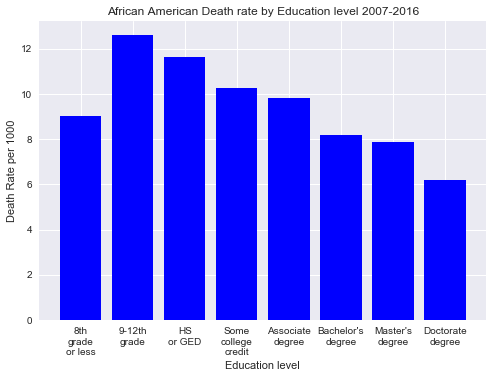

In [86]:
x_axis = exclude_excluded_aar['Education']
y_axis = exclude_excluded_aar['Death Rate']
plt.tight_layout()
plt.title(f"African American Death rate by Education level 2007-2016")
plt.ylabel("Death Rate per 1000")
plt.xlabel("Education level")
plt.bar(x_axis, y_axis, color="b", align="center")
plt.xticks(range(len(x_axis)), ["8th\ngrade\nor less", "9-12th\ngrade", "HS\nor GED", "Some\ncollege\ncredit" , "Associate\ndegree", "Bachelor's\ndegree", "Master's\ndegree", "Doctorate\ndegree"] )

plt.savefig("Images/Education_of_AAR.png")
plt.show()

In [87]:
censusaareducation = 'datafiles/AAR_Education_2013_2017.csv'
censusaareducation_df = pd.read_csv(censusaareducation, encoding="ISO-8859-1")


In [88]:
censusaareducation_df.dropna()

,Education,2013,2014,2015,2016,2017,total,2013%,2014%,2015%,2016%,2017%,Average
0,8th grade or less,921,889,778,907,773,4268,3.183767,3.020830,2.592556,2.978165,2.516194,2.858302
1,9th through 12th grade with no diploma,3570,3439,3308,3293,3241,16851,12.340985,11.685752,11.023360,10.812674,10.549787,11.282512
2,High school graduate or GED completed,"9,696","9,993","10,268","10,319","10,249","50,525",33.517699,33.956302,34.216402,33.882778,33.361544,33.786945
3,"Some college credit, but not a degree","6,658","6,639","6,899","6,942","6,857","33,995",23.015763,22.559380,22.989770,22.794287,22.320237,22.735887
4,"Associate degree (AA, AS)","2,551",2720,2758,"2,695",2937,13661,8.818446,9.242584,9.190576,8.849122,9.560236,9.132193
5,"Bachelor's degree (BA, AB, BS)","3,657","3,835","3,901","4,074","4,301","19,768",12.641731,13.031364,12.999434,13.377114,14.000195,13.209967
6,"Master's degree (MA, MS)","1,506","1,529","1,689","1,789","1,872","8,385",5.206029,5.195555,5.628312,5.874241,6.093552,5.599538
7,"Doctorate (PHD, EdD) or Professional Degree (M...",369,385,408,436,491,"2,089",1.275581,1.308233,1.359592,1.431620,1.598255,1.394656


### Level of Education of African Americans 2013-2017

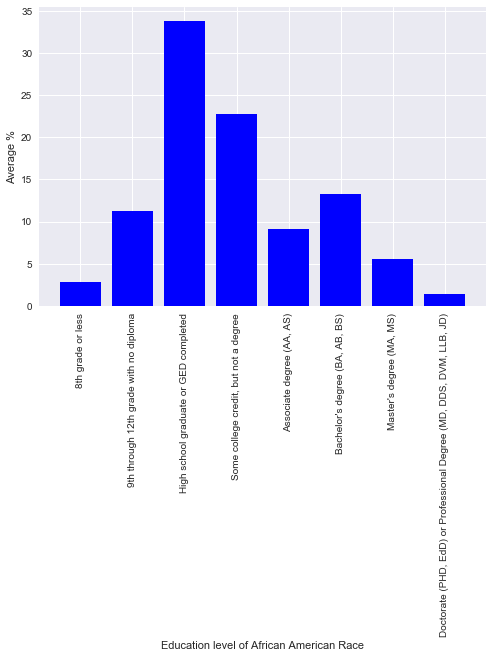

In [89]:
x_axis = censusaareducation_df['Education']
y_axis = censusaareducation_df['Average']
plt.tight_layout()
plt.ylabel("Average %")
plt.xlabel("Education level of African American Race")
plt.bar(x_axis, y_axis, color="b", align="center")
plt.xticks(censusaareducation_df['Education'], rotation="vertical")

plt.savefig("Images/Census_Education_of_AAR.png")
plt.show()

## Birth Weight and IMR

In [90]:
file= "datafiles/birth_weight.csv"
birthweight_df=pd.read_csv(file)
birthweight_df

,Birth Weight Code,code,Deaths,Births,"Death Rate Per 1,000"
0,499 grams or less,1,5473,6434,850.64
1,500 - 999 grams,2,5025,20442,245.82
2,1000 - 1499 grams,3,1379,29087,47.41
3,1500 - 1999 grams,4,1614,62880,25.67
4,2000 - 2499 grams,5,1965,203883,9.64
5,2500 - 2999 grams,6,2720,730726,3.72
6,3000 - 3499 grams,7,2956,1527728,1.93
7,3500 - 3999 grams,8,1418,1048489,1.35
8,4000 - 4499 grams,9,379,269872,1.40
9,4500 - 4999 grams,10,58,38264,1.52


In [91]:
total_rate = list(birthweight_df["Death Rate Per 1,000"])

In [92]:
birthweight_df

,Birth Weight Code,code,Deaths,Births,"Death Rate Per 1,000"
0,499 grams or less,1,5473,6434,850.64
1,500 - 999 grams,2,5025,20442,245.82
2,1000 - 1499 grams,3,1379,29087,47.41
3,1500 - 1999 grams,4,1614,62880,25.67
4,2000 - 2499 grams,5,1965,203883,9.64
5,2500 - 2999 grams,6,2720,730726,3.72
6,3000 - 3499 grams,7,2956,1527728,1.93
7,3500 - 3999 grams,8,1418,1048489,1.35
8,4000 - 4499 grams,9,379,269872,1.40
9,4500 - 4999 grams,10,58,38264,1.52


In [93]:
list_rate = []
sum_rate = birthweight_df["Death Rate Per 1,000"].sum()
for rate in total_rate:
    rate_percent = (rate / sum_rate) * 100
    list_rate.append(rate_percent)

In [94]:
birthweight_df["Deaths Rate"] =list_rate
birthweight_df["Deaths Percent (%)"] = birthweight_df["Deaths Rate"].map("{0:.2f}%".format)

In [95]:
birthweight_df

,Birth Weight Code,code,Deaths,Births,"Death Rate Per 1,000",Deaths Rate,Deaths Percent (%)
0,499 grams or less,1,5473,6434,850.64,68.842615,68.84%
1,500 - 999 grams,2,5025,20442,245.82,19.894305,19.89%
2,1000 - 1499 grams,3,1379,29087,47.41,3.836909,3.84%
3,1500 - 1999 grams,4,1614,62880,25.67,2.077483,2.08%
4,2000 - 2499 grams,5,1965,203883,9.64,0.780169,0.78%
5,2500 - 2999 grams,6,2720,730726,3.72,0.301061,0.30%
6,3000 - 3499 grams,7,2956,1527728,1.93,0.156196,0.16%
7,3500 - 3999 grams,8,1418,1048489,1.35,0.109256,0.11%
8,4000 - 4499 grams,9,379,269872,1.40,0.113303,0.11%
9,4500 - 4999 grams,10,58,38264,1.52,0.123014,0.12%


In [96]:
rate_percent = list(birthweight_df["Deaths Rate"])
birth_weight = list(birthweight_df["Birth Weight Code"])

In [97]:
bw_x_axis = birth_weight
bw_y_axis = rate_percent

In [98]:
birthweight_df["Birth Weight Code"]

0     499 grams or less
1       500 - 999 grams
2     1000 - 1499 grams
3     1500 - 1999 grams
4     2000 - 2499 grams
5     2500 - 2999 grams
6     3000 - 3499 grams
7     3500 - 3999 grams
8     4000 - 4499 grams
9     4500 - 4999 grams
10    5000 - 8165 grams
11           Not stated
Name: Birth Weight Code, dtype: object

In [99]:
birthweight_df["Deaths Rate"]

0     68.842615
1     19.894305
2      3.836909
3      2.077483
4      0.780169
5      0.301061
6      0.156196
7      0.109256
8      0.113303
9      0.123014
10     0.323722
11     3.441969
Name: Deaths Rate, dtype: float64

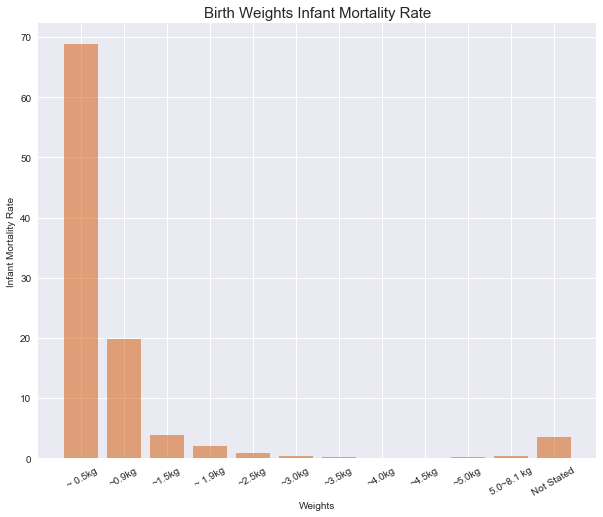

In [100]:
label = [" ~ 0.5kg", "~0.9kg", "~1.5kg", "~ 1.9kg", "~2.5kg", "~3.0kg", "~3.5kg","~4.0kg","~4.5kg", "~5.0kg","5.0~8.1 kg","Not Stated"]
plt.figure(figsize=(10,8))
plt.bar(bw_x_axis, bw_y_axis, color = "#D35400", alpha = 0.5,align ="center")
plt.title(f"Birth Weights Infant Mortality Rate",fontsize=15)
plt.xlabel("Weights", fontsize= 10)
plt.ylabel("Infant Mortality Rate",fontsize= 10)
plt.xticks(bw_x_axis, label, fontsize=10, rotation=30)
plt.savefig("Images/bw_Birth Weights Infant Mortality Rate.png")
plt.show()

In [101]:
file= "datafiles/total_low_brith_weight_by_race.csv"
total_birthweight_df=pd.read_csv(file)
total_birthweight_df

,Race,Data Type,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,American Indian,Number,"3,586","3,686","3,663","3,538","3,557","3,501","3,504","3,435","3,434","3,332"
1,NaN,Percent,7.50%,7.50%,7.40%,7.30%,7.60%,7.50%,7.60%,7.50%,7.60%,7.50%
2,Asian and Pacific Islander,Number,"19,539","20,601","20,685","20,741","20,938","21,200","22,388","22,148","22,755","23,617"
3,NaN,Percent,8.10%,8.10%,8.20%,8.30%,8.50%,8.40%,8.20%,8.30%,8.10%,8.40%
4,Black or African American,Number,"90,445","91,422","89,659","87,360","83,881","82,018","81,244","80,814","82,108","83,316"
5,NaN,Percent,13.60%,13.60%,13.40%,13.30%,13.20%,13.00%,12.80%,12.80%,12.80%,13.00%
6,Hispanic or Latino,Number,"72,538","73,661","72,398","69,356","65,868","64,449","63,190","63,832","64,424","66,623"
7,NaN,Percent,7.00%,6.90%,7.00%,6.90%,7.00%,7.00%,7.00%,7.10%,7.10%,7.20%
8,Non-Hispanic White,Number,"168,871","167,986","163,561","158,954","154,325","152,047","148,636","148,390","149,574","147,479"
9,NaN,Percent,7.30%,7.30%,7.20%,7.20%,7.10%,7.10%,7.00%,7.00%,7.00%,6.90%


In [102]:
for i in range(6,10):
    total_birthweight_df[f"200{i}"]=total_birthweight_df[f"200{i}"].str.replace("%", "")

In [103]:
for i in range(10,16):
    total_birthweight_df[f"20{i}"]=total_birthweight_df[f"20{i}"].str.replace("%", "")

In [104]:
total_birthweight_df

,Race,Data Type,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,American Indian,Number,"3,586","3,686","3,663","3,538","3,557","3,501","3,504","3,435","3,434","3,332"
1,NaN,Percent,7.50,7.50,7.40,7.30,7.60,7.50,7.60,7.50,7.60,7.50
2,Asian and Pacific Islander,Number,"19,539","20,601","20,685","20,741","20,938","21,200","22,388","22,148","22,755","23,617"
3,NaN,Percent,8.10,8.10,8.20,8.30,8.50,8.40,8.20,8.30,8.10,8.40
4,Black or African American,Number,"90,445","91,422","89,659","87,360","83,881","82,018","81,244","80,814","82,108","83,316"
5,NaN,Percent,13.60,13.60,13.40,13.30,13.20,13.00,12.80,12.80,12.80,13.00
6,Hispanic or Latino,Number,"72,538","73,661","72,398","69,356","65,868","64,449","63,190","63,832","64,424","66,623"
7,NaN,Percent,7.00,6.90,7.00,6.90,7.00,7.00,7.00,7.10,7.10,7.20
8,Non-Hispanic White,Number,"168,871","167,986","163,561","158,954","154,325","152,047","148,636","148,390","149,574","147,479"
9,NaN,Percent,7.30,7.30,7.20,7.20,7.10,7.10,7.00,7.00,7.00,6.90


In [105]:
for i in range(6,10):
    total_birthweight_df[f"200{i}"]=total_birthweight_df[f"200{i}"].str.replace(",", "")
    total_birthweight_df[f"200{i}"]=total_birthweight_df[f"200{i}"].astype(float)

In [106]:
for i in range(10,16):
    total_birthweight_df[f"20{i}"]=total_birthweight_df[f"20{i}"].str.replace(",", "")
    total_birthweight_df[f"20{i}"]=total_birthweight_df[f"20{i}"].astype(float)

In [107]:
total_birthweight_df['2006'].astype(float)
total_birthweight_df.dtypes

Race          object
Data Type     object
2006         float64
2007         float64
2008         float64
2009         float64
2010         float64
2011         float64
2012         float64
2013         float64
2014         float64
2015         float64
dtype: object

In [108]:
percent_race_df = pd.DataFrame(total_birthweight_df[total_birthweight_df["Data Type"].isin(["Percent"])])
total_race_df =pd.DataFrame(total_birthweight_df[total_birthweight_df["Data Type"].isin(["Number"])])

In [109]:
race_list = list(total_race_df["Race"])

In [110]:
race_list = race_list[0:5]

In [111]:
percent_race_df=percent_race_df.iloc[0:5]

In [112]:
percent_race_df["Race"] = race_list

In [113]:
percent_race_df=percent_race_df.set_index("Race")
total_race_df=total_race_df.set_index("Race")

In [114]:
percent_race_df = percent_race_df.drop("Data Type",axis=1)

In [115]:
total_race_df=total_race_df.drop("Data Type",axis=1)

In [116]:
average_percent_race_list = []
for race in race_list :
    average_percent_race_list.append(percent_race_df.loc[f"{race}"].mean())

In [117]:
percent_race_df["Average %"] = average_percent_race_list

In [118]:
percent_race_df.dtypes

2006         float64
2007         float64
2008         float64
2009         float64
2010         float64
2011         float64
2012         float64
2013         float64
2014         float64
2015         float64
Average %    float64
dtype: object

In [119]:
percent_race_df

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Average %
Race,,,,,,,,,,,
American Indian,7.5,7.5,7.4,7.3,7.6,7.5,7.6,7.5,7.6,7.5,7.50
Asian and Pacific Islander,8.1,8.1,8.2,8.3,8.5,8.4,8.2,8.3,8.1,8.4,8.26
Black or African American,13.6,13.6,13.4,13.3,13.2,13.0,12.8,12.8,12.8,13.0,13.15
Hispanic or Latino,7.0,6.9,7.0,6.9,7.0,7.0,7.0,7.1,7.1,7.2,7.02
Non-Hispanic White,7.3,7.3,7.2,7.2,7.1,7.1,7.0,7.0,7.0,6.9,7.11


In [120]:
bw_race_x_axis = race_list 
bw_race_y_axis = list(percent_race_df["Average %"])

In [121]:
bw_race_y_axis

[7.5, 8.26, 13.15, 7.0200000000000005, 7.110000000000001]

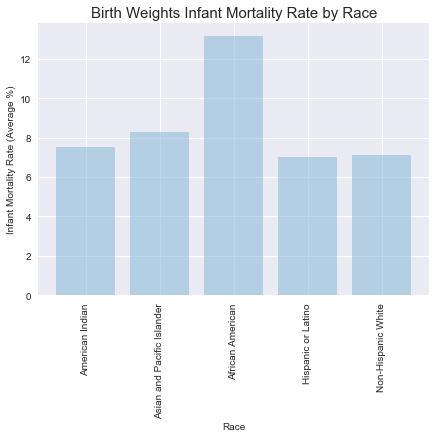

In [122]:
label = ['American Indian', 'Asian and Pacific Islander', 'African American', 'Hispanic or Latino', 'Non-Hispanic White']
plt.figure(figsize=(7,5))
plt.bar(bw_race_x_axis, bw_race_y_axis, color = "#7FB3D5", alpha = 0.5,align ="center")
plt.title(f"Birth Weights Infant Mortality Rate by Race",fontsize=15)
plt.xlabel("Race", fontsize= 10)
plt.ylabel("Infant Mortality Rate (Average %)",fontsize= 10)
plt.xticks(bw_race_x_axis, label, fontsize=10, rotation=90)
plt.savefig("Images/bw_Birth Weights Infant Mortality Rate by Race.png")
plt.show()

In [123]:
file= "datafiles/overweight_rates.csv"
overweight_df=pd.read_csv(file)
overweight_df

,Location,American Indian,Asian and Pacific Islander,African American,Hispanic or Latino,Non-Hispanic White
0,United States,71.8,41.9,72.4,71.0,64.7


In [124]:
overweight_df = overweight_df.set_index("Location")

In [125]:
list_overweight = list(overweight_df.loc['United States'])

In [126]:
list_overweight

[71.8, 41.9, 72.4, 71.0, 64.7]

In [127]:
overweight_df.dtypes

American Indian               float64
Asian and Pacific Islander    float64
African American              float64
Hispanic or Latino            float64
Non-Hispanic White            float64
dtype: object

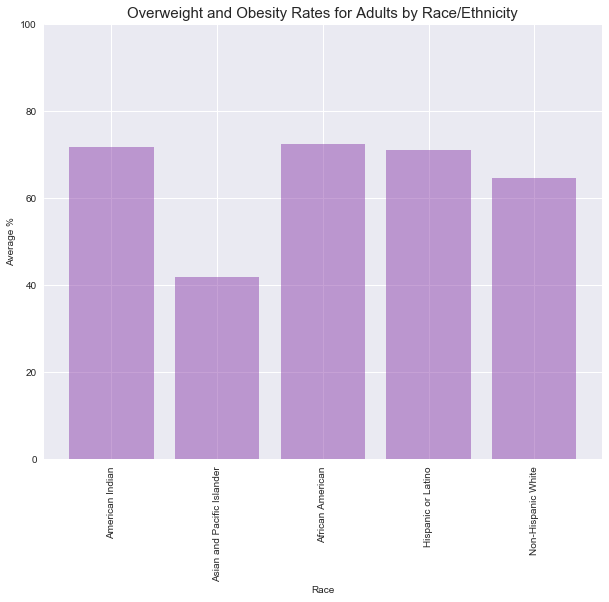

In [128]:
label = ['American Indian', 'Asian and Pacific Islander', 'African American', 'Hispanic or Latino', 'Non-Hispanic White']
plt.figure(figsize=(10,8))
plt.bar(label,list_overweight, color = "#8E44AD", alpha = 0.5,align ="center")
plt.title(f"Overweight and Obesity Rates for Adults by Race/Ethnicity",fontsize=15)
plt.xlabel("Race", fontsize= 10)
plt.ylabel("Average %",fontsize= 10)
plt.xticks(fontsize=10, rotation=90)
plt.ylim(0,100)
plt.savefig("Images/bw_Overweight and Obesity Rates for Adults by Race.png")
plt.show()
#plt.xticks(x_axis, label, fontsize=10, rotation=90)

In [129]:
file= "datafiles/total_rate_hypertension_race.csv"
hypertension_df=pd.read_csv(file)
hypertension_df

,Location,American Indian,Asian and Pacific Islander,African American,Hispanic or Latino,Non-Hispanic White
0,United States,31.9,15.2,39.0,20.6,32.4


In [130]:
hypertension_df.dtypes

Location                       object
American Indian               float64
Asian and Pacific Islander    float64
African American              float64
Hispanic or Latino            float64
Non-Hispanic White            float64
dtype: object

In [131]:
hypertension_df =hypertension_df.set_index("Location")

In [132]:
list_hypertension=list(hypertension_df.loc["United States"])

In [133]:
list_hypertension

[31.9, 15.2, 39.0, 20.6, 32.4]

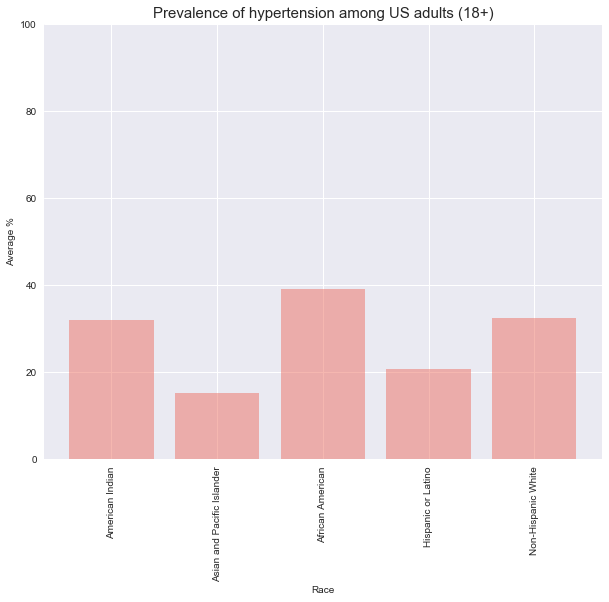

In [134]:
label = ['American Indian', 'Asian and Pacific Islander', 'African American', 'Hispanic or Latino', 'Non-Hispanic White']
plt.figure(figsize=(10,8))
plt.bar(label,list_hypertension, color = "#EC7063", alpha = 0.5,align ="center")
plt.title(f"Prevalence of hypertension among US adults (18+)",fontsize=15)
plt.xlabel("Race", fontsize= 10)
plt.ylabel("Average %",fontsize= 10)
plt.xticks(fontsize=10, rotation=90)
plt.ylim(0,100)
plt.savefig("Images/bw_Prevalence of hypertension among US adults.png")
plt.show()

In [135]:
file= "datafiles/IMR_by_race.csv"
IMR_df=pd.read_csv(file)
IMR_df

,Location,American Indian,Asian and Pacific Islander,African American,Hispanic or Latino,Non-Hispanic White
0,United States,7.61,4.075,11.11,5.0,5.06


In [136]:
IMR_df=IMR_df.set_index("Location")

In [137]:
list_IMR_rate=list(IMR_df.loc["United States"])

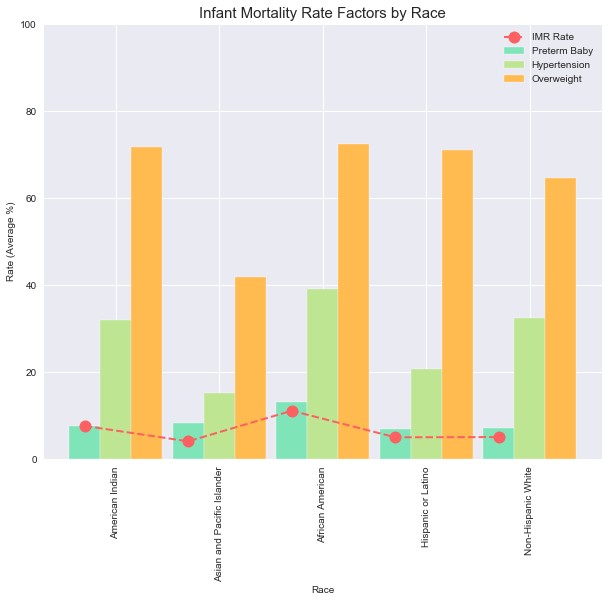

In [138]:
label = ['American Indian', 'Asian and Pacific Islander', 'African American', 'Hispanic or Latino', 'Non-Hispanic White']
bar_width=0.3
plt.figure(figsize=(10,8))
r1=np.arange(len(label))
r2=[x + bar_width for x in r1]
r3=[x + bar_width for x in r2]
plt.bar(r1, bw_race_y_axis,color = "#7fe5b9",width=bar_width,edgecolor='white', label='Preterm Baby')
plt.bar(r2,list_hypertension, color = "#bde592",width=bar_width,edgecolor='white', label='Hypertension')
plt.bar(r3,list_overweight, color = "#ffba50", width=bar_width,edgecolor='white', label='Overweight')
plt.plot(label, list_IMR_rate,label = "IMR Rate",color = "#fc6060", marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.title(f"Infant Mortality Rate Factors by Race",fontsize=15)
plt.xlabel("Race", fontsize= 10)
plt.ylabel("Rate (Average %)",fontsize= 10)
plt.xticks([r+bar_width for r in range(len(label))],['American Indian', 'Asian and Pacific Islander', 'African American', 'Hispanic or Latino', 'Non-Hispanic White'], fontsize=10, rotation=90)
plt.ylim(0,100)
plt.legend()
plt.savefig("Images/bw_IMR Factors by Race.png", bbox_inches="tight")
plt.show()

### IMR and Economic Factors

In [139]:
#read census poverty data
poverty_df = pd.read_csv('datafiles/2007_2016_poverty.csv')

In [140]:
poverty_df.head()

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),All Ages in Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),Median Household Income in Dollars,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
0,2016,1,1001,Autauga County (AL),"54,939","7,444","6,255","8,633","6,255 to 8,633",13.5,...,NaN,NaN,NaN,NaN,NaN,NaN,"$54,487","$50,886","$58,088","$50,886 to $58,088"
1,2015,1,1001,Autauga County (AL),"54,860","6,966","5,673","8,259","5,673 to 8,259",12.7,...,NaN,NaN,NaN,NaN,NaN,NaN,"$56,580","$51,459","$61,701","$51,459 to $61,701"
2,2014,1,1001,Autauga County (AL),"54,903","7,204","5,845","8,563","5,845 to 8,563",13.1,...,NaN,NaN,NaN,NaN,NaN,NaN,"$54,366","$50,916","$57,816","$50,916 to $57,816"
3,2013,1,1001,Autauga County (AL),"54,762","7,397","6,109","8,685","6,109 to 8,685",13.5,...,NaN,NaN,NaN,NaN,NaN,NaN,"$51,868","$48,314","$55,422","$48,314 to $55,422"
4,2012,1,1001,Autauga County (AL),"55,059","7,017","5,688","8,346","5,688 to 8,346",12.7,...,NaN,NaN,NaN,NaN,NaN,NaN,"$51,441","$47,185","$55,697","$47,185 to $55,697"


In [141]:
#only keep needed columns
poverty_df = poverty_df[["Year","County ID","State / County Name","All Ages in Poverty Percent"]]

In [142]:
poverty_df.head()

,Year,County ID,State / County Name,All Ages in Poverty Percent
0,2016,1001,Autauga County (AL),13.5
1,2015,1001,Autauga County (AL),12.7
2,2014,1001,Autauga County (AL),13.1
3,2013,1001,Autauga County (AL),13.5
4,2012,1001,Autauga County (AL),12.7


In [143]:
#group by the County ID
poverty_group = poverty_df.groupby(["County ID"]).mean()

In [144]:
poverty_group.head()

,Year,All Ages in Poverty Percent
County ID,,
1001,2011.5,12.46
1003,2011.5,12.59
1005,2011.5,28.27
1007,2011.5,20.29
1009,2011.5,15.19


In [145]:
#read table of lat/lng cooridnates for counties
location_df = pd.read_csv('datafiles/2017_counties.csv', encoding="ISO-8859-1")

In [146]:
location_df = location_df.rename(columns={'GEOID': "County ID","INTPTLAT": "Lat","INTPTLONG": "Lng"})

In [147]:
location_df.head()

,USPS,County ID,NAME,Lat,Lng
0,AL,1001,Autauga County,32.532237,-86.646440
1,AL,1003,Baldwin County,30.659218,-87.746067
2,AL,1005,Barbour County,31.870253,-85.405104
3,AL,1007,Bibb County,33.015893,-87.127148
4,AL,1009,Blount County,33.977358,-86.566440


In [148]:
#combine poverty data with county location data
merge_table = pd.merge(poverty_df, location_df, on="County ID", how="left")

In [149]:
merge_table.head()

,Year,County ID,State / County Name,All Ages in Poverty Percent,USPS,NAME,Lat,Lng
0,2016,1001,Autauga County (AL),13.5,AL,Autauga County,32.532237,-86.64644
1,2015,1001,Autauga County (AL),12.7,AL,Autauga County,32.532237,-86.64644
2,2014,1001,Autauga County (AL),13.1,AL,Autauga County,32.532237,-86.64644
3,2013,1001,Autauga County (AL),13.5,AL,Autauga County,32.532237,-86.64644
4,2012,1001,Autauga County (AL),12.7,AL,Autauga County,32.532237,-86.64644


In [150]:
#group by County ID
merge_group = merge_table.groupby(["County ID"]).mean()

In [151]:
merge_group.head()

,Year,All Ages in Poverty Percent,Lat,Lng
County ID,,,,
1001,2011.5,12.46,32.532237,-86.646440
1003,2011.5,12.59,30.659218,-87.746067
1005,2011.5,28.27,31.870253,-85.405104
1007,2011.5,20.29,33.015893,-87.127148
1009,2011.5,15.19,33.977358,-86.566440


In [152]:
#remove rows with missing values
merge_group = merge_group.dropna(how="any")

In [153]:
merge_group.head()

,Year,All Ages in Poverty Percent,Lat,Lng
County ID,,,,
1001,2011.5,12.46,32.532237,-86.646440
1003,2011.5,12.59,30.659218,-87.746067
1005,2011.5,28.27,31.870253,-85.405104
1007,2011.5,20.29,33.015893,-87.127148
1009,2011.5,15.19,33.977358,-86.566440


In [154]:
#load API key
gmaps.configure(api_key=gkey)

In [155]:
#construct heat map of poverty levels from 2007-2016
locations = merge_group[["Lat", "Lng"]].astype(float)
poverty_rate = merge_group["All Ages in Poverty Percent"].astype(float)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=poverty_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = .6)

In [156]:
fig.add_layer(heat_layer)

fig


Figure(layout=FigureLayout(height='420px'))

In [157]:
#read CDC data on top 15 states for infant death rates
death_rates_state_top_df = pd.read_csv('datafiles/death_rates_state_top.csv')

In [158]:
death_rates_state_top_df

,State,State Code,Deaths,Births,Death Rate,Lat,Lng
0,Mississippi,28,3823,406596,9.40,32.741646,-89.678696
1,Alabama,1,5349,606074,8.83,32.806671,-86.791130
2,District of Columbia,11,812,93126,8.72,38.897438,-77.026817
3,Louisiana,22,5287,639021,8.27,31.169546,-91.867805
4,Delaware,10,886,113424,7.81,39.318523,-75.507141
5,Oklahoma,40,4044,535082,7.56,35.565342,-96.928917
6,Arkansas,5,2950,390960,7.55,34.969704,-92.373123
7,North Carolina,37,9279,1232890,7.53,35.630066,-79.806419
8,Ohio,39,10648,1415822,7.52,40.388783,-82.764915
9,Tennessee,47,6140,818022,7.51,35.747845,-86.692345


In [159]:
#drop location markers on the 15 states
locations_state = death_rates_state_top_df[["Lat", "Lng"]].astype(float)
state_layer = gmaps.symbol_layer(
    locations_state, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=4)

fig = gmaps.figure()
fig.add_layer(state_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [160]:
#combine poverty heatmap with state location
fig = gmaps.figure()
fig.add_layer(heat_layer)
fig.add_layer(state_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [161]:
#read CDC data on death rates per county for 2006-2017
death_rates_county = pd.read_csv('datafiles/death_rates.csv')

In [162]:
death_rates_county.head()

,County,County Code,Deaths,Births,Death Rate
0,"Jefferson County, AL",1073,983,91579,10.73
1,"Madison County, AL",1089,332,41740,7.95
2,"Mobile County, AL",1097,512,57785,8.86
3,"Unidentified Counties, AL",1999,3522,414970,8.49
4,"Anchorage Borough, AK",2020,234,46436,5.04


In [163]:
death_rates_county = death_rates_county.rename(columns={"County Code": "County ID"})

In [164]:
death_rates_county.head()

,County,County ID,Deaths,Births,Death Rate
0,"Jefferson County, AL",1073,983,91579,10.73
1,"Madison County, AL",1089,332,41740,7.95
2,"Mobile County, AL",1097,512,57785,8.86
3,"Unidentified Counties, AL",1999,3522,414970,8.49
4,"Anchorage Borough, AK",2020,234,46436,5.04


In [165]:
#merge CDC data on death rates per county with poverty and county location data
regress_df = pd.merge(death_rates_county, merge_group, on="County ID", how="left")

In [166]:
regress_df.head()

,County,County ID,Deaths,Births,Death Rate,Year,All Ages in Poverty Percent,Lat,Lng
0,"Jefferson County, AL",1073,983,91579,10.73,2011.5,17.30,33.553444,-86.896536
1,"Madison County, AL",1089,332,41740,7.95,2011.5,12.69,34.764238,-86.551080
2,"Mobile County, AL",1097,512,57785,8.86,2011.5,19.71,30.684572,-88.196568
3,"Unidentified Counties, AL",1999,3522,414970,8.49,NaN,NaN,NaN,NaN
4,"Anchorage Borough, AK",2020,234,46436,5.04,2011.5,8.35,61.174250,-149.284329


In [167]:
#remove all rows with missing values
regress_df = regress_df.dropna(how="any")

In [168]:
regress_df.head()

,County,County ID,Deaths,Births,Death Rate,Year,All Ages in Poverty Percent,Lat,Lng
0,"Jefferson County, AL",1073,983,91579,10.73,2011.5,17.30,33.553444,-86.896536
1,"Madison County, AL",1089,332,41740,7.95,2011.5,12.69,34.764238,-86.551080
2,"Mobile County, AL",1097,512,57785,8.86,2011.5,19.71,30.684572,-88.196568
4,"Anchorage Borough, AK",2020,234,46436,5.04,2011.5,8.35,61.174250,-149.284329
6,"Maricopa County, AZ",4013,3291,567145,5.80,2011.5,15.88,33.346541,-112.495534


In [169]:
#define x and y axis for regression analsys
x_axis = regress_df["All Ages in Poverty Percent"]
y_axis = regress_df["Death Rate"]

In [170]:
(slope, intercept, _, _, _) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept

In [171]:
#calculate statistical values
slope, intercept, r_value, p_value, std_err = linregress(x_axis, y_axis)

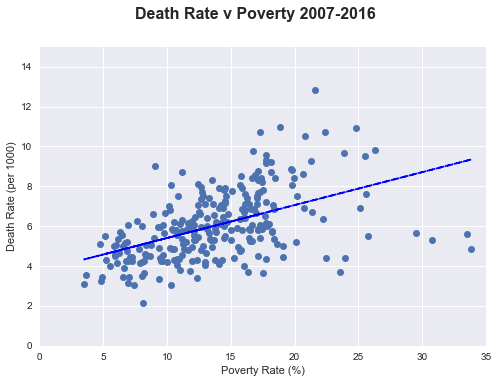

In [172]:
#perform linear regression of death rate versus poverty
fig, ax = plt.subplots()

fig.suptitle("Death Rate v Poverty 2007-2016", fontsize=16, fontweight="bold")

ax.set_xlim(0,35)
ax.set_ylim(0,15)

ax.set_xlabel("Poverty Rate (%)")
ax.set_ylabel("Death Rate (per 1000)")

ax.plot(x_axis, y_axis, linewidth=0, marker='o')
ax.plot(x_axis, fit, 'b--')
plt.savefig("Images/deathrateVpoverty_linregress.png")
plt.show()

In [173]:
p_value

9.850728813612898e-18

In [174]:
#start health insurance analysis
insurance_df = pd.read_csv("datafiles/insurance.csv")

In [175]:
insurance_df.head()

,State,Year,Total,Private,Public
0,Alabama,2017.0,96.9,55.0,45.8
1,Alabama,2016.0,97.3,55.8,44.8
2,Alabama,2015.0,96.8,55.9,45.0
3,Alabama,2014.0,95.8,55.2,44.4
4,Alabama,2013.0,95.2,55.5,43.6


In [176]:
death_rates_state = pd.read_csv("datafiles/death_rates_state.txt", delimiter="\t")

In [177]:
death_rates_state = death_rates_state[["State","Death Rate"]]

In [178]:
death_rates_state = death_rates_state.dropna(how="any")

In [179]:
death_rates_state.head()

,State,Death Rate
0,Alabama,8.83
1,Alaska,5.65
2,Arizona,5.93
3,Arkansas,7.55
4,California,4.71


In [180]:
insurance_group = insurance_df.groupby("State").mean()

In [181]:
insurance_group.head()

,Year,Total,Private,Public
State,,,,
Alabama,2012.5,95.16,56.93,41.90
Alaska,2012.5,87.96,60.11,32.79
Arizona,2012.5,88.46,54.97,36.96
Arkansas,2012.5,93.89,47.87,49.89
California,2012.5,92.96,56.08,40.19


In [182]:
insurance_merge = pd.merge(death_rates_state, insurance_group, on="State", how="left")

In [183]:
insurance_merge.head()

,State,Death Rate,Year,Total,Private,Public
0,Alabama,8.83,2012.5,95.16,56.93,41.90
1,Alaska,5.65,2012.5,87.96,60.11,32.79
2,Arizona,5.93,2012.5,88.46,54.97,36.96
3,Arkansas,7.55,2012.5,93.89,47.87,49.89
4,California,4.71,2012.5,92.96,56.08,40.19


In [184]:
x_axis = insurance_merge["Total"]
y_axis = insurance_merge["Death Rate"]

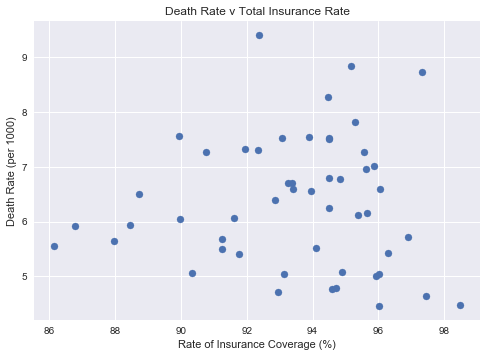

In [185]:
#graph the death rate versus total rate of insurance for all states
plt.scatter(x_axis, y_axis)
plt.ylabel("Death Rate (per 1000)")
plt.xlabel("Rate of Insurance Coverage (%)")
plt.title("Death Rate v Total Insurance Rate")
plt.savefig("Images/DeathRate_v_TotalInsurance.png")

In [186]:
(slope, intercept, _, _, _) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
slope, intercept, r_value, p_value, std_err = linregress(x_axis, y_axis)

In [187]:
p_value

0.9836866811526419

In [188]:
x2_axis = insurance_merge["Public"]

In [189]:
insurance_merge = insurance_merge.dropna(how="any")

In [190]:
insurance_merge.dtypes

State          object
Death Rate    float64
Year          float64
Total         float64
Private       float64
Public        float64
dtype: object

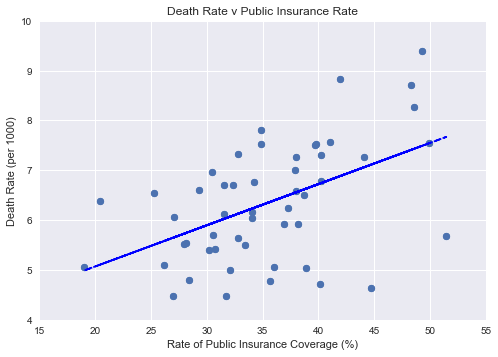

In [191]:
#plot death rate versus rate of public insurance
(slope, intercept, _, _, _) = linregress(x2_axis, y_axis)
fit = slope * x2_axis + intercept
slope, intercept, r_value, p_value, std_err = linregress(x2_axis, y_axis)

fig, ax = plt.subplots()

fig.suptitle("", fontsize=16, fontweight="bold")

ax.set_xlim(15,55)
ax.set_ylim(4,10)

ax.plot(x2_axis, y_axis, linewidth=0, marker='o')
ax.plot(x2_axis, fit, 'b--')
plt.scatter(x2_axis, y_axis)
plt.ylabel("Death Rate (per 1000)")
plt.xlabel("Rate of Public Insurance Coverage (%)")
plt.title("Death Rate v Public Insurance Rate")
plt.savefig("Images/DeathRate_v_PublicInsurance.png")
plt.show()


In [192]:
p_value

0.00018406689781009939

In [193]:
x3_axis = insurance_merge["Private"]

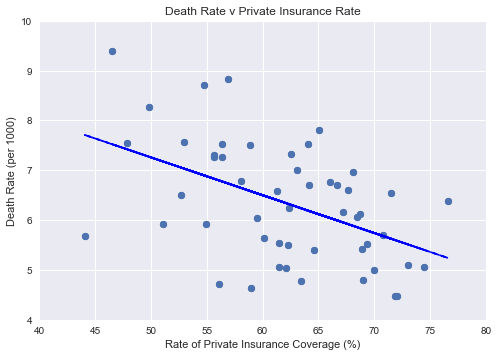

In [194]:
#plot death rate versus rate of private insurance
(slope, intercept, _, _, _) = linregress(x3_axis, y_axis)
fit = slope * x3_axis + intercept
slope, intercept, r_value, p_value, std_err = linregress(x3_axis, y_axis)

fig, ax = plt.subplots()

fig.suptitle("", fontsize=16, fontweight="bold")

ax.set_xlim(40,80)
ax.set_ylim(4,10)

ax.plot(x3_axis, y_axis, linewidth=0, marker='o')
ax.plot(x3_axis, fit, 'b--')
plt.scatter(x3_axis, y_axis)
plt.ylabel("Death Rate (per 1000)")
plt.xlabel("Rate of Private Insurance Coverage (%)")
plt.title("Death Rate v Private Insurance Rate")
plt.savefig("Images/DeathRate_v_PrivateInsurance")
plt.show()


In [195]:
p_value

0.0003313122078554712

In [196]:
#Start new analysis on top ten and bottom ten african american counties regarding death rate
AfricanAmerican20 = pd.read_csv("datafiles/AfricanAmerican20.csv")

In [197]:
AfricanAmerican20

,County Code,Race Code,Deaths,Births,Death Rate
0,18003,2054-5,152,8647,17.58
1,22017,2054-5,376,22127,16.99
2,34001,2054-5,118,7219,16.35
3,39061,2054-5,612,38789,15.78
4,34021,2054-5,195,12363,15.77
5,6019,2054-5,151,9587,15.75
6,1073,2054-5,662,42655,15.52
7,36001,2054-5,103,6652,15.48
8,18141,2054-5,109,7068,15.42
9,20173,2054-5,147,9541,15.41


In [198]:
AfricanAmerican20 = AfricanAmerican20.rename(columns={"County Code": "County ID"})

In [199]:
african_merge = pd.merge(AfricanAmerican20, merge_group, on="County ID", how="left")

In [200]:
african_merge = african_merge[["County ID","Death Rate","All Ages in Poverty Percent"]]

In [201]:
african_merge

,County ID,Death Rate,All Ages in Poverty Percent
0,18003,17.58,14.57
1,22017,16.99,21.58
2,34001,16.35,13.53
3,39061,15.78,16.75
4,34021,15.77,10.83
5,6019,15.75,25.12
6,1073,15.52,17.30
7,36001,15.48,12.83
8,18141,15.42,16.66
9,20173,15.41,14.65


In [202]:
x_axis = african_merge["All Ages in Poverty Percent"]
y_axis = african_merge["Death Rate"]

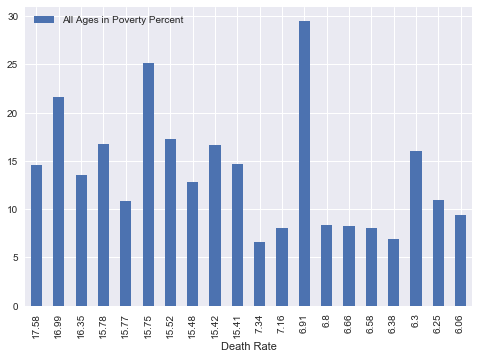

In [203]:
african_merge.set_index("County ID").plot.bar("Death Rate")

In [204]:
black_counties = pd.read_csv("datafiles/black_counties.csv")

In [205]:
black_counties.head()

,County ID,Race,Race Code,Deaths,Births,Death Rate
0,1073,Black or African American,2054-5,662,42655,15.52
1,1089,Black or African American,2054-5,152,12260,12.40
2,1097,Black or African American,2054-5,302,24396,12.38
3,1999,Black or African American,2054-5,1395,107618,12.96
4,2020,Black or African American,2054-5,23,3381,6.80


In [206]:
black_merge = pd.merge(black_counties, merge_group, on="County ID", how="left")

In [207]:
black_merge = black_merge.dropna(how="any")

In [208]:
black_merge.head()

,County ID,Race,Race Code,Deaths,Births,Death Rate,Year,All Ages in Poverty Percent,Lat,Lng
0,1073,Black or African American,2054-5,662,42655,15.52,2011.5,17.30,33.553444,-86.896536
1,1089,Black or African American,2054-5,152,12260,12.40,2011.5,12.69,34.764238,-86.551080
2,1097,Black or African American,2054-5,302,24396,12.38,2011.5,19.71,30.684572,-88.196568
4,2020,Black or African American,2054-5,23,3381,6.80,2011.5,8.35,61.174250,-149.284329
5,4013,Black or African American,2054-5,420,36714,11.44,2011.5,15.88,33.346541,-112.495534


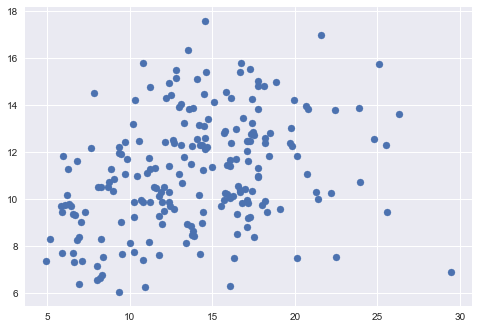

In [209]:
x_axis = black_merge["All Ages in Poverty Percent"]
y_axis = black_merge["Death Rate"]
plt.scatter(x_axis, y_axis)

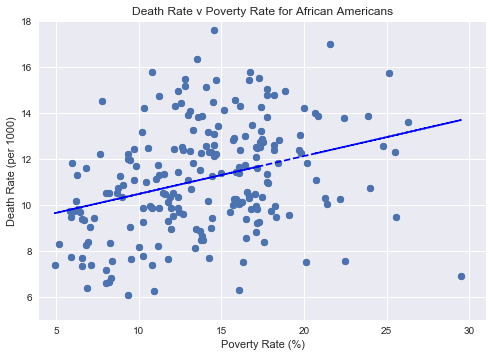

In [210]:
#plot death rate versus poverty rate for African Americans
(slope, intercept, _, _, _) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
slope, intercept, r_value, p_value, std_err = linregress(x_axis, y_axis)

fig, ax = plt.subplots()

fig.suptitle("", fontsize=16, fontweight="bold")

ax.set_xlim(4,31)
ax.set_ylim(5,18)

ax.plot(x_axis, y_axis, linewidth=0, marker='o')
ax.plot(x_axis, fit, 'b--')
plt.scatter(x_axis, y_axis)
plt.ylabel("Death Rate (per 1000)")
plt.xlabel("Poverty Rate (%)")
plt.title("Death Rate v Poverty Rate for African Americans")
plt.savefig("Images/DeathRate_v_AfricanAmericanPoverty.png")
plt.show()

In [211]:
p_value

1.504149016359755e-06

In [212]:
white_counties = pd.read_csv("datafiles/white_counties.csv")

In [213]:
white_counties.head()

,County ID,Race,Race Code,Deaths,Births,Death Rate
0,1073,White,2106-3,317,46960,6.75
1,1089,White,2106-3,177,28040,6.31
2,1097,White,2106-3,198,31675,6.25
3,1999,White,2106-3,2085,299903,6.95
4,2020,White,2106-3,120,29466,4.07


In [214]:
white_merge = pd.merge(white_counties, merge_group, on="County ID", how="left")

In [215]:
white_merge = white_merge.dropna(how="any")

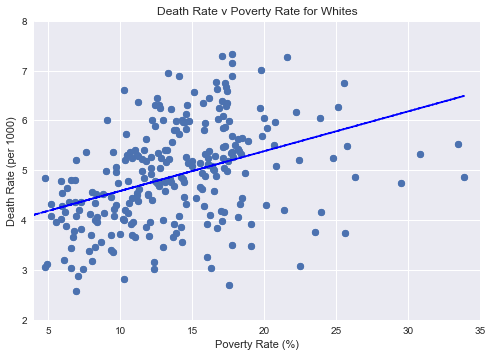

In [216]:
#plot death rate versus poverty rate for Whites
x_axis = white_merge["All Ages in Poverty Percent"]
y_axis = white_merge["Death Rate"]

(slope, intercept, _, _, _) = linregress(x_axis, y_axis)
fit = slope * x_axis + intercept
slope, intercept, r_value, p_value, std_err = linregress(x_axis, y_axis)

fig, ax = plt.subplots()

fig.suptitle("", fontsize=16, fontweight="bold")

ax.set_xlim(4,35)
ax.set_ylim(2,8)

ax.plot(x_axis, y_axis, linewidth=0, marker='o')
ax.plot(x_axis, fit, 'b--')
plt.scatter(x_axis, y_axis)
plt.ylabel("Death Rate (per 1000)")
plt.xlabel("Poverty Rate (%)")
plt.title("Death Rate v Poverty Rate for Whites")
plt.savefig("Images/DeathRate_v_PovertyRateWhites.png")
plt.show()

In [217]:
p_value

1.168129133468144e-11

In [218]:
#Heatmap with poverty per county and top ten counties deathrate
regress_df = regress_df.sort_values(by=["Death Rate"], ascending=False)

In [219]:
regress_df = regress_df.reset_index()

In [220]:
regress_df.head()

,index,County,County ID,Deaths,Births,Death Rate,Year,All Ages in Poverty Percent,Lat,Lng
0,115,"Caddo Parish, LA",22017,486,37838,12.84,2011.5,21.58,32.577195,-93.882423
1,116,"East Baton Rouge Parish, LA",22033,680,61916,10.98,2011.5,18.84,30.543930,-91.093131
2,153,"Hinds County, MS",28049,276,25226,10.94,2011.5,24.79,32.267788,-90.466017
3,127,"Baltimore city, MD",24510,976,90996,10.73,2011.5,22.42,39.300032,-76.610476
4,0,"Jefferson County, AL",1073,983,91579,10.73,2011.5,17.30,33.553444,-86.896536


In [221]:
regress_df = regress_df.iloc[0:10]

In [222]:
regress_df

,index,County,County ID,Deaths,Births,Death Rate,Year,All Ages in Poverty Percent,Lat,Lng
0,115,"Caddo Parish, LA",22017,486,37838,12.84,2011.5,21.58,32.577195,-93.882423
1,116,"East Baton Rouge Parish, LA",22033,680,61916,10.98,2011.5,18.84,30.543930,-91.093131
2,153,"Hinds County, MS",28049,276,25226,10.94,2011.5,24.79,32.267788,-90.466017
3,127,"Baltimore city, MD",24510,976,90996,10.73,2011.5,22.42,39.300032,-76.610476
4,0,"Jefferson County, AL",1073,983,91579,10.73,2011.5,17.30,33.553444,-86.896536
5,264,"Shelby County, TN",47157,1482,140867,10.52,2011.5,20.83,35.183794,-89.895397
6,159,"St. Louis city, MO",29510,482,48971,9.84,2011.5,26.30,38.635699,-90.244582
7,216,"Hamilton County, OH",39061,1087,111518,9.75,2011.5,16.75,39.196927,-84.544187
8,146,"Wayne County, MI",26163,2337,241580,9.67,2011.5,23.87,42.284664,-83.261953
9,205,"Cumberland County, NC",37051,548,57261,9.57,2011.5,17.75,35.050192,-78.828719


In [223]:
regress_df.to_csv("datafiles/low_IMR_county.csv")

In [224]:
gmaps.configure(api_key=gkey)
#construct heat map of poverty levels from 2007-2016
locations = merge_group[["Lat", "Lng"]].astype(float)
poverty_rate = merge_group["All Ages in Poverty Percent"].astype(float)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=poverty_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = .6)

#drop location markers on the 10 counties
locations_county = regress_df[["Lat", "Lng"]].astype(float)
county_layer = gmaps.symbol_layer(
    locations_county, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=4)

fig = gmaps.figure()
fig.add_layer(heat_layer)
fig.add_layer(county_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [225]:
#
# Logan Caldwell
#

%matplotlib notebook

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

mothers_age_state_csv = "datafiles/mothers_age_state_grouped.csv"

df_mothers_age_state = pd.read_csv(mothers_age_state_csv)

df_mothers_age_state.head(15)


,State,State Code,County,County Code,Age of Mother,Age of Mother Code,Deaths,Births,Death Rate
0,Alabama,1.0,"Jefferson County, AL",1073.0,20-24 years,20-24,24.0,1886.0,12.73
1,Alabama,1.0,"Jefferson County, AL",1073.0,25-29 years,25-29,26.0,2650.0,9.81
2,Alabama,1.0,"Jefferson County, AL",1073.0,30-34 years,30-34,25.0,2384.0,10.49
3,Alabama,1.0,"Madison County, AL",1089.0,25-29 years,25-29,10.0,1360.0,7.35 (Unreliable)
4,Alabama,1.0,"Mobile County, AL",1097.0,20-24 years,20-24,17.0,1586.0,10.72 (Unreliable)
5,Alabama,1.0,"Mobile County, AL",1097.0,25-29 years,25-29,12.0,1751.0,6.85 (Unreliable)
6,Alabama,1.0,"Mobile County, AL",1097.0,30-34 years,30-34,14.0,1172.0,11.95 (Unreliable)
7,Alabama,1.0,"Unidentified Counties, AL",1999.0,15-19 years,15-19,34.0,3325.0,10.23
8,Alabama,1.0,"Unidentified Counties, AL",1999.0,20-24 years,20-24,117.0,11707.0,9.99
9,Alabama,1.0,"Unidentified Counties, AL",1999.0,25-29 years,25-29,97.0,12888.0,7.53


In [226]:
df_mothers_age_state.describe()

### Dropna working correctly here??
df_mothers_age_state.dropna(axis=0, how="any")
df_mothers_age_state["Age of Mother"].unique()

array(['20-24 years', '25-29 years', '30-34 years', '15-19 years',
       '35-39 years', '40-44 years', nan], dtype=object)

In [227]:
df_mothers_age_state.mean()

State Code        28.001565
County Code    28355.599374
Deaths            28.884194
Births          4676.508607
dtype: float64

In [228]:
ages_15_19 = df_mothers_age_state[df_mothers_age_state["Age of Mother"] == "15-19 years"]
ages_20_24 = df_mothers_age_state[df_mothers_age_state["Age of Mother"] == "20-24 years"]
ages_25_29 = df_mothers_age_state[df_mothers_age_state["Age of Mother"] == "25-29 years"]
ages_30_34 = df_mothers_age_state[df_mothers_age_state["Age of Mother"] == "30-34 years"]
ages_35_39 = df_mothers_age_state[df_mothers_age_state["Age of Mother"] == "35-39 years"]
ages_40_44 = df_mothers_age_state[df_mothers_age_state["Age of Mother"] == "40-44 years"]

ages_15_19["Death Rate"] = ages_15_19["Death Rate"].str.replace("\s*\(Unreliable\)", "")
ages_20_24["Death Rate"] = ages_20_24["Death Rate"].str.replace("\s*\(Unreliable\)", "")
ages_25_29["Death Rate"] = ages_25_29["Death Rate"].str.replace("\s*\(Unreliable\)", "")
ages_30_34["Death Rate"] = ages_30_34["Death Rate"].str.replace("\s*\(Unreliable\)", "")
ages_35_39["Death Rate"] = ages_35_39["Death Rate"].str.replace("\s*\(Unreliable\)", "")
ages_40_44["Death Rate"] = ages_40_44["Death Rate"].str.replace("\s*\(Unreliable\)", "")

C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [229]:
ages_15_19["Death Rate"] = ages_15_19["Death Rate"].astype(float)
ages_20_24["Death Rate"] = ages_20_24["Death Rate"].astype(float)
ages_25_29["Death Rate"] = ages_25_29["Death Rate"].astype(float)
ages_30_34["Death Rate"] = ages_30_34["Death Rate"].astype(float)
ages_35_39["Death Rate"] = ages_35_39["Death Rate"].astype(float)
ages_40_44["Death Rate"] = ages_40_44["Death Rate"].astype(float)

ages_15_19_IMR_mean = (ages_15_19["Death Rate"].mean())
ages_20_24_IMR_mean = (ages_20_24["Death Rate"].mean())
ages_25_29_IMR_mean = (ages_25_29["Death Rate"].mean())
ages_30_34_IMR_mean = (ages_30_34["Death Rate"].mean())
ages_35_39_IMR_mean = (ages_35_39["Death Rate"].mean())
ages_40_44_IMR_mean = (ages_40_44["Death Rate"].mean())

IMR_rate_means_by_age_list = [ages_15_19_IMR_mean,ages_20_24_IMR_mean,ages_25_29_IMR_mean,ages_30_34_IMR_mean,ages_35_39_IMR_mean,ages_40_44_IMR_mean]
IMR_rate_means_by_age_list

C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

[10.331632653061227,
 8.381103448275864,
 6.3341758241758255,
 5.59811320754717,
 6.527252747252748,
 9.461538461538462]

In [230]:
df_mothers_age_state_means = df_mothers_age_state.mean()
df_mothers_age_state_means.head()

State Code        28.001565
County Code    28355.599374
Deaths            28.884194
Births          4676.508607
dtype: float64

In [231]:
df_mothers_age_state.set_index("State")
df_mothers_age_state_grouped = df_mothers_age_state.groupby(by="State", group_keys=True,)
df_mothers_age_state.mean()

State Code        28.001565
County Code    28355.599374
Deaths            28.884194
Births          4676.508607
dtype: float64

In [232]:
age_ticks = [0,1,2,3,4,5]
age_ranges_list = ["15-19", "20-24", "25-29", "30-34", "35-39", "40-44"]

x=[0,1,2,3,4,5]

<IPython.core.display.Javascript object>


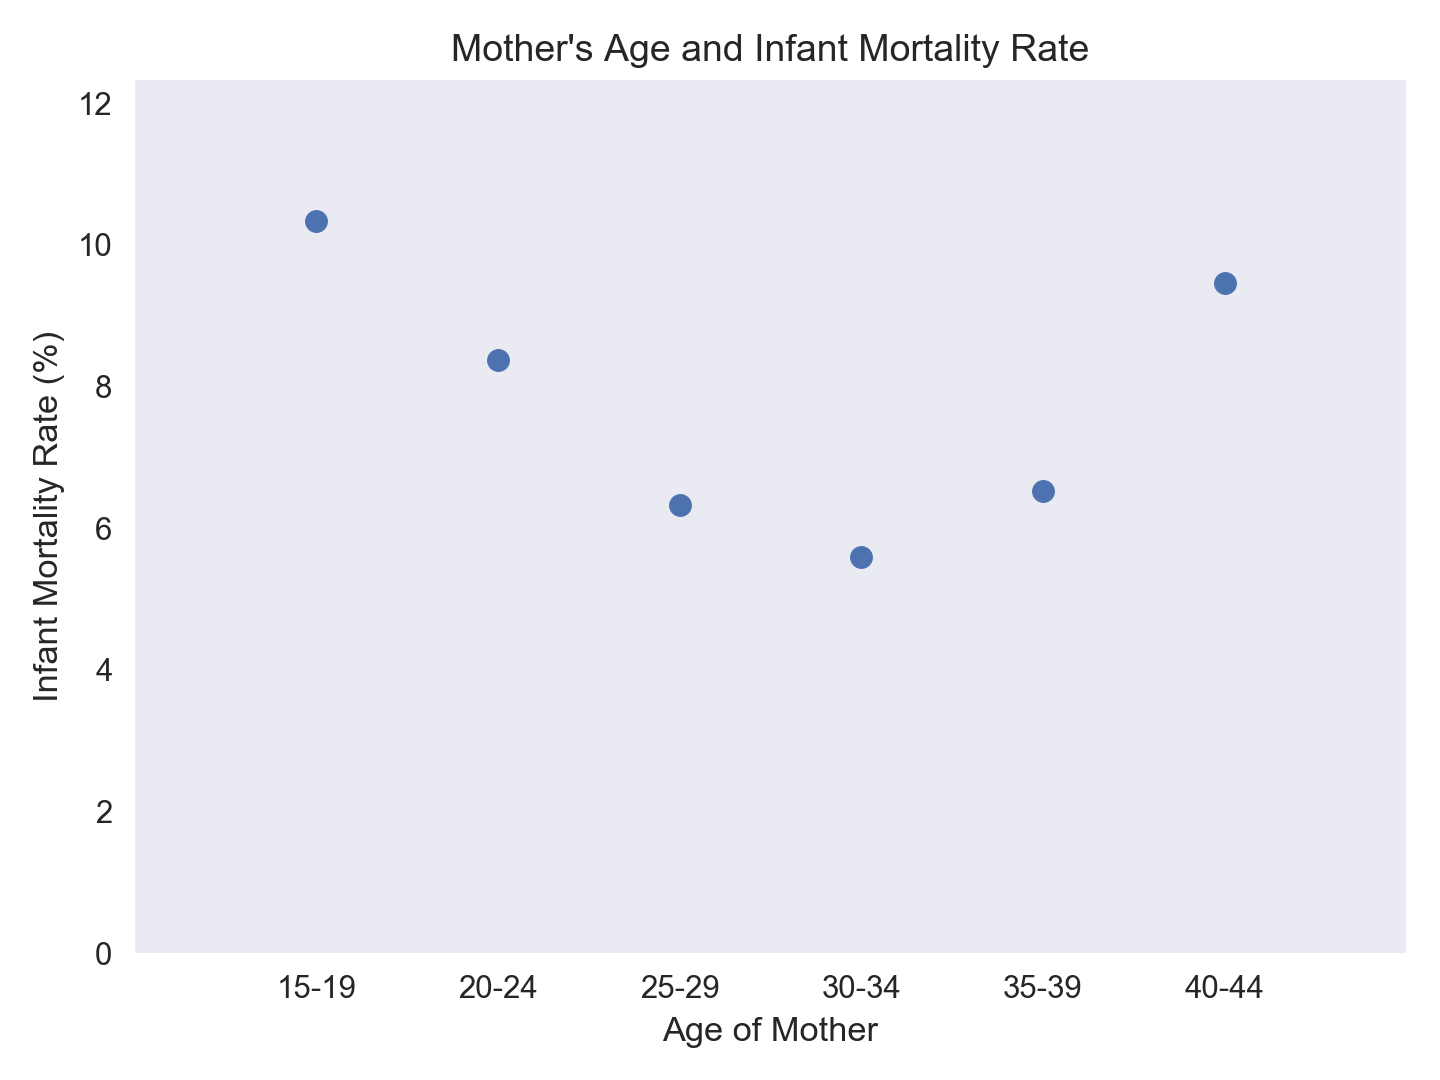

In [233]:
m_age_IMR_plot = plt.scatter(age_ranges_list, IMR_rate_means_by_age_list, )

In [234]:
plt.title("Mother's Age and Infant Mortality Rate")
plt.xlabel("Age of Mother")
plt.ylabel("Infant Mortality Rate (%)")
plt.grid()
plt.xlim(-1,6)
plt.ylim(0, max(IMR_rate_means_by_age_list)+2)
plt.tight_layout()

In [235]:
plt.savefig("Images/IMR_and_age_of_mother_plot")

In [236]:
plt.show()